# Tuning and training MC and ML models on Base Dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats


import json

from sklearn.model_selection import KFold

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torchvision.transforms import functional, Resize

import time
from datetime import datetime
from tqdm import tqdm

from model_utils import ModelWrapper, myDataLoader, IteratedFRace
from model_utils import num_to_bin_string, bin_to_num, num_to_bin, ml_to_mc, mc_to_ml
from model_utils import bitwise_accuracy
from model_utils import sigmoid_accuracy, softmax_accuracy, bitwise_accuracy, bitwise_recall, bitwise_precision, bitwise_F1,\
    macro_metrics, hamming_distances, mean_hamming_distance


In [3]:
sns.set_theme(style="darkgrid", font_scale=1.1)
PAL = sns.color_palette('bright')

DATASETS = os.path.join('..', '..', 'Datasets', 'numpy_datasets')
MODEL_PATH = os.path.join('..', 'models')
PLOTS = os.path.join('..', 'plots')
EVAL = os.path.join('..', 'evals')
ML_LOGS = os.path.join('..', 'opt_logs', 'ml_tuning')
MC_LOGS = os.path.join('..', 'opt_logs', 'mc_tuning')


## Data processing

In [4]:
angelina = os.path.join(DATASETS, "angelina.npz")
dsbi = os.path.join(DATASETS, "dsbi.npz")

data = np.load(angelina)
ood = np.load(dsbi)
print(data['train_x'].shape)
print(ood['test_x'].shape)

(69267, 40, 30, 3)
(45627, 40, 30, 3)


In [5]:
train_X = data["train_x"] / 255.
train_Y = data["train_y"]

val_X = data["val_x"] / 255.
val_Y = data["val_y"]

test_X = data["test_x"] / 255.
test_Y = data["test_y"]

N, p = train_Y.shape

In [6]:
train_Y_cat = ml_to_mc(train_Y)
val_Y_cat = ml_to_mc(val_Y)
test_Y_cat = ml_to_mc(test_Y)

C = train_Y_cat.shape[1]

In [7]:
ood_X = ood['test_x'] / 255.
ood_Y = ood['test_y']
ood_Y_cat = ml_to_mc(ood_Y)

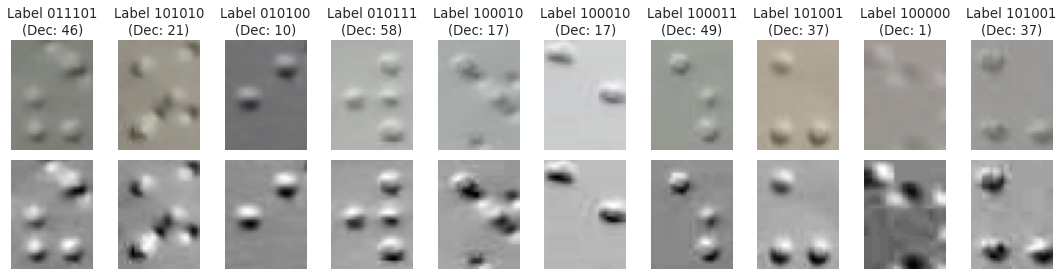

In [8]:
plt.figure(figsize=(15,4))
np.random.seed(101010)
subset = np.random.choice(np.arange(0, N), 10)

for i in range(10):
    sample = (train_X[subset[i]]).astype(np.float32)
    plt.subplot(2,10, i+1)
    plt.axis("off")
    lbl = ''.join(train_Y[subset[i]].astype(str))
    num_lbl = np.argmax(train_Y_cat[subset[i]])
    plt.imshow(sample)
    plt.title("Label {}\n(Dec: {})".format(lbl, num_lbl))
    
    gray = cv2.cvtColor(sample, cv2.COLOR_RGB2GRAY)
    plt.subplot(2,10, i+11)
    plt.axis("off")
    plt.gray()
    plt.imshow(gray)
plt.tight_layout()

### Modeling framework testing

In [12]:
DEBUG = False

In [13]:
train_loader = myDataLoader(train_X, train_Y, batch_sz=16)
val_loader = myDataLoader(train_X, train_Y, batch_sz=16)
# filters 31, kernel_sz 5,  dense_sz 111, activs relu, padding 0,  in_sz torch.Size([40, 30, 3]), grey 0, sqr 0
model = ModelWrapper(in_size=(40,30,3), out_size=6, dev='cuda')

if DEBUG:
    test_hist = model.train(train_loader, val_loader, epochs=10, patience=2, verbose=1)
    test_t = model.reevaluate(train_loader)
    test_v = model.reevaluate(val_loader)

In [14]:
if DEBUG:
    train_pred = model.predict(train_loader)
    train_pred[:5]

Model training time

- With neither - 50s per training epoch, 28s per re-evaluation
    - Note, last two epochs seem out-of-the-norm. Avg of first 3: 34s per training epoch, 11s per re-evaluation
- With Grey scaling - 43s per training epoch, 20s per re-evaluation
    - Note, last two epochs seem out-of-the-norm. Avg of first 3: 35s per training epoch, 13s per re-evaluation
- With Square resizing - 42s per training epoch, 17s per re-evaluation
    - Note, last two epochs seem out-of-the-norm. Avg of first 3: 25s per training epoch, 8s per re-evaluation
- With both - 35s per training epoch, 21s per re-evaluation
    - Note, last two epochs seem out-of-the-norm. Avg of first 3: 22s per training epoch, 7s per re-evaluation

In [15]:
if DEBUG:
    save_path = os.path.join(MODEL_PATH, 'trial_model_20240828')
    model.save(save_path)
    new_model = ModelWrapper(dev='cpu')
    new_model.load(save_path)
    model.reevaluate(train_loader)

## FRace Results

In [9]:
param_space = {
    'lr': (0.0001, 0.02),
    'beta_1': (0.85, 0.95),
    'beta_2': (0.99, 0.9999),
    'l2': (0.0001, 0.03),
    'filters': (8, 64),
    'kernel_sz': (2,5),
    'dense_sz': (25, 150),
    'activs': (0, 2),
    'padding': (0, 1),
    'grey': (0, 1),
    'sqr': (0, 1)
}

param_names = [
    'Learning Rate', 'Beta1', 'Beta2', 'L2 Penalty',
    'Num Filters', 'Kernel Size', 'Dense Layer Size',
    'Activation function', 'Padding', 
    'Grey scaling', 'Square Input'
]

activations = {
    0: F.relu,
    1: F.tanh,
    2: F.leaky_relu
}

In [10]:
base_models_v0 = "20240910_055505"

log_path_ml = os.path.join(ML_LOGS, f"base_{base_models_v0}_elite_set.json")
log_path_mc = os.path.join(MC_LOGS, f"base_{base_models_v0}_elite_set.json")

In [11]:
with open(log_path_ml, 'r') as log_json:
    ml_elite_result = json.load(log_json)

with open(log_path_ml.replace('elite', 'historic'), 'r') as log_json:
    ml_history = json.load(log_json)

ml_history_df = pd.DataFrame(ml_history['model_configs']).T
ml_history_df.columns = param_space.keys()

ml_history_df['mean_loss'] = pd.DataFrame(ml_history['final_scores'], index=['mean_loss']).T.sort_index(key=lambda x: x.astype(int))
ml_highest = str(ml_elite_result['final_ranks'][0])
ml_history_df.head()

lr    beta_1    beta_2        l2  filters  kernel_sz  dense_sz  \
0  0.002136  0.888950  0.990567  0.006406     45.0        4.0     141.0   
1  0.006105  0.939367  0.999391  0.014646     25.0        2.0      43.0   
2  0.009267  0.850455  0.993948  0.000556     40.0        3.0     115.0   
3  0.002687  0.902479  0.995971  0.019128     56.0        5.0      87.0   
4  0.004955  0.873281  0.998574  0.015797     58.0        4.0      94.0   

   activs  padding  grey  sqr  mean_loss  
0     1.0      0.0   1.0  0.0   0.423855  
1     0.0      1.0   0.0  1.0   0.657886  
2     1.0      1.0   0.0  1.0   0.658366  
3     2.0      0.0   1.0  0.0   0.657892  
4     1.0      1.0   0.0  1.0   0.657341

In [12]:
with open(log_path_mc, 'r') as log_json:
    mc_elite_result = json.load(log_json)

with open(log_path_mc.replace('elite', 'historic'), 'r') as log_json:
    mc_history = json.load(log_json)

mc_history_df = pd.DataFrame(mc_history['model_configs']).T
mc_history_df.columns = param_space.keys()

mc_history_df['mean_loss'] = pd.DataFrame(mc_history['final_scores'], index=['mean_loss']).T.sort_index(key=lambda x: x.astype(int))
mc_highest = str(mc_elite_result['final_ranks'][0])
mc_history_df.head()

lr    beta_1    beta_2        l2  filters  kernel_sz  dense_sz  \
0  0.007985  0.887414  0.995392  0.009277     25.0        4.0     106.0   
1  0.002098  0.902379  0.994222  0.015718     40.0        2.0      26.0   
2  0.004570  0.855944  0.998913  0.003829     58.0        3.0     132.0   
3  0.005507  0.933945  0.990009  0.012632     31.0        4.0      84.0   
4  0.007364  0.869717  0.993063  0.014453     37.0        4.0     144.0   

   activs  padding  grey  sqr  mean_loss  
0     0.0      1.0   0.0  0.0   3.429972  
1     1.0      0.0   1.0  1.0   3.424782  
2     2.0      0.0   1.0  1.0   3.427080  
3     1.0      1.0   0.0  0.0   3.430880  
4     2.0      0.0   1.0  1.0   3.431789

### Results Visualisation

In [38]:
iterations = [0] * 20 + [1] * 19 + [2] * 19 + [3] * 19 + [4] * 19

ml_history_df['iteration'] = iterations
mc_history_df['iteration'] = iterations


<Axes: xlabel='lr', ylabel='iteration'>

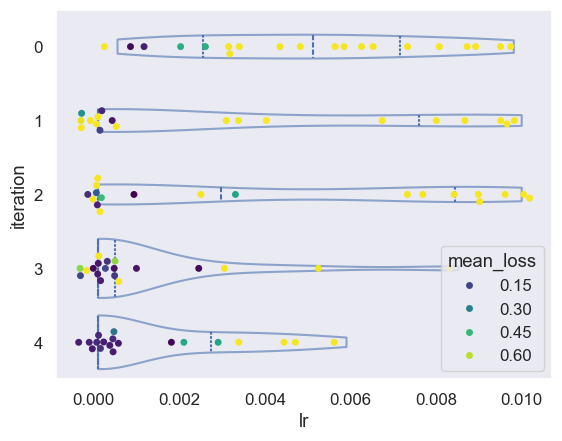

In [87]:
sns.violinplot(data=ml_history_df, x='lr', y='iteration', orient='h', fill=False, cut=0, alpha=0.6, inner='quart')
r = max(ml_history_df['lr']) - min(ml_history_df['lr'])
dx = ml_history_df['lr'] + ((np.random.rand(ml_history_df.shape[0]) * r - r/2) / 10 )
sns.swarmplot(data=ml_history_df, x=dx, y='iteration', hue='mean_loss', orient='h', palette='viridis')

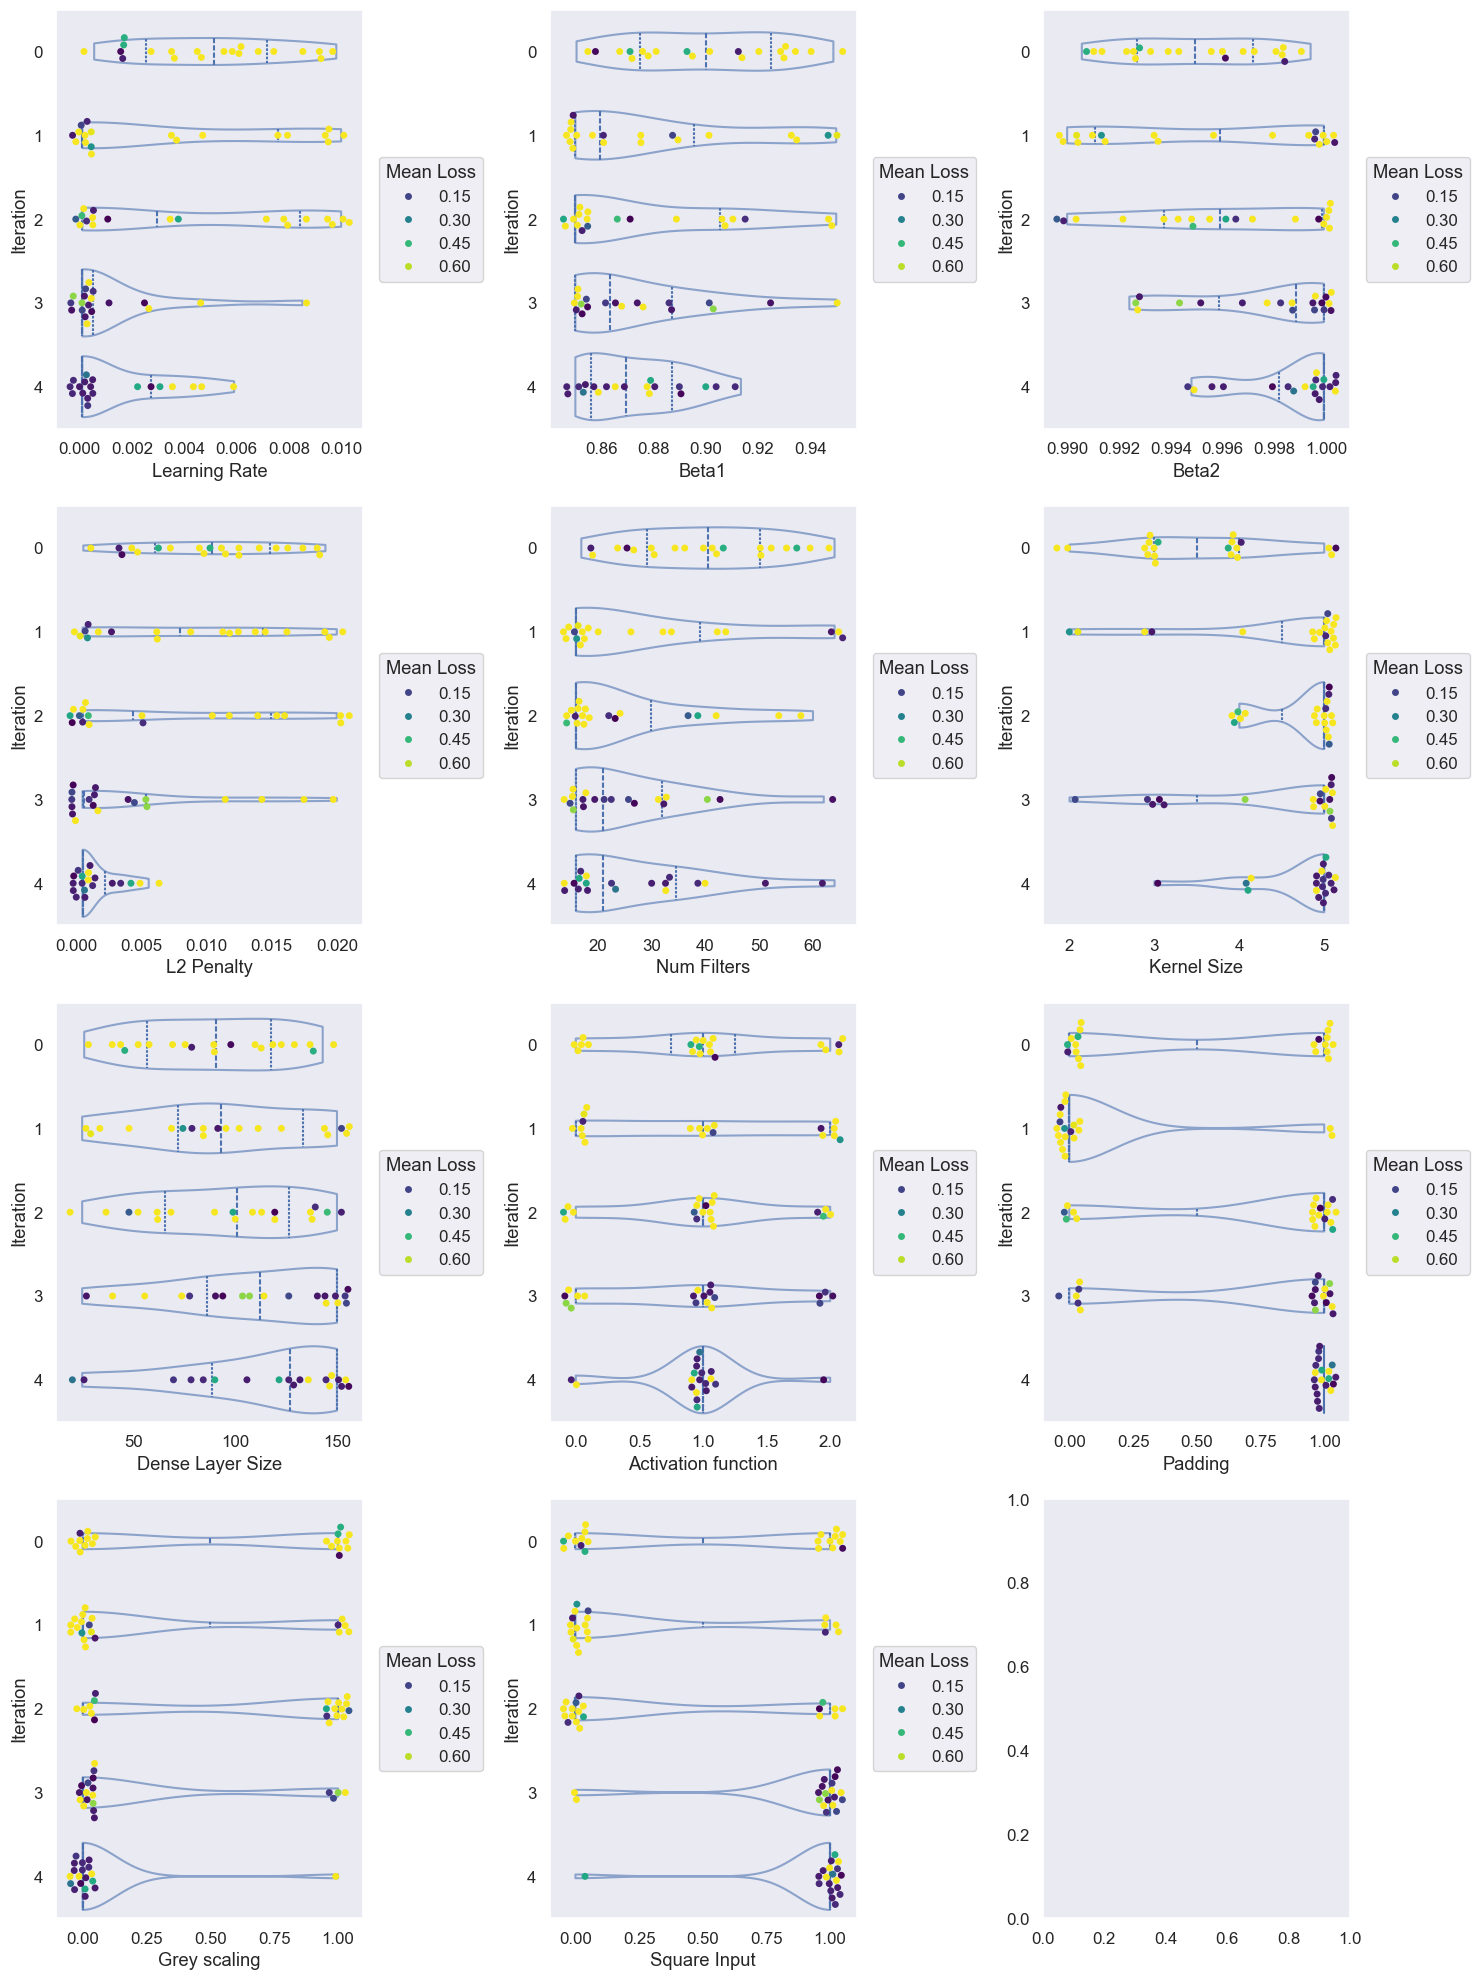

In [90]:
fig, axes = plt.subplots(4, 3, figsize=(15,20))

for i in range(11):
    attr = list(param_space.keys())[i]
    ax = axes[i // 3, i % 3]
    sns.violinplot(data=ml_history_df, x=attr, y='iteration', orient='h', fill=False, cut=0, alpha=0.6, inner='quart', ax=ax)
    r = max(ml_history_df[attr]) - min(ml_history_df[attr])
    dx = ml_history_df[attr] + ((np.random.rand(ml_history_df.shape[0]) * r - r/2) / 10 )
    sns.swarmplot(data=ml_history_df, x=dx, y='iteration', hue='mean_loss', orient='h', palette='viridis', ax=ax)
    
    leg = ax.legend(loc='center left', bbox_to_anchor=(1.025, 0.5))
    leg.set_title('Mean Loss')
    ax.set_xlabel(param_names[i])
    ax.set_ylabel('Iteration')
plt.tight_layout()

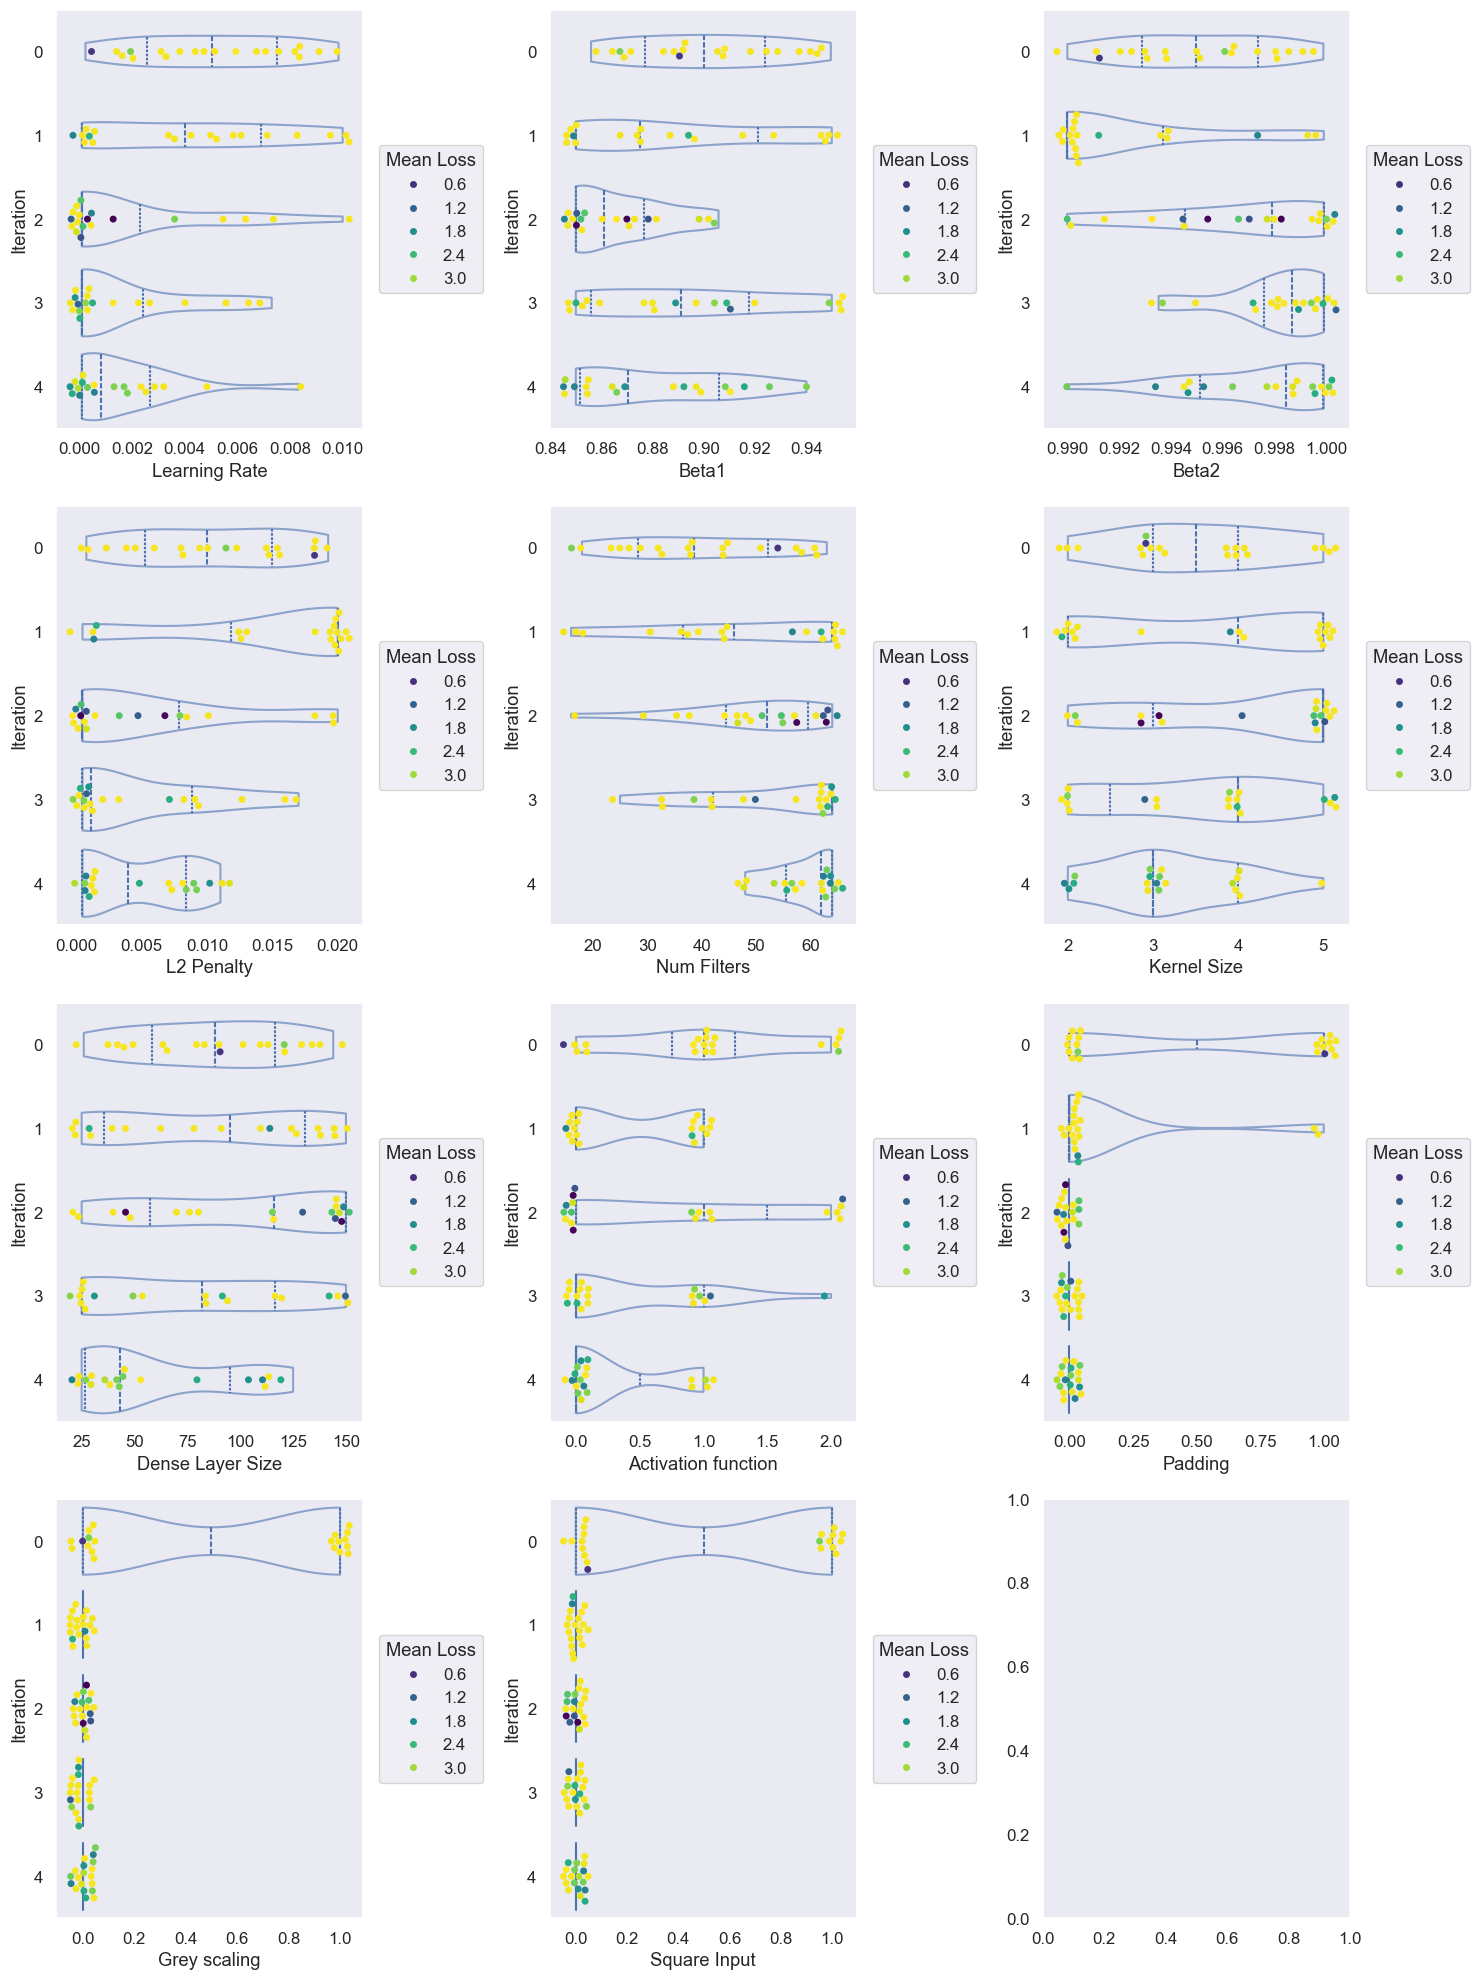

In [91]:
fig, axes = plt.subplots(4, 3, figsize=(15,20))

for i in range(11):
    attr = list(param_space.keys())[i]
    ax = axes[i // 3, i % 3]
    sns.violinplot(data=mc_history_df, x=attr, y='iteration', orient='h', fill=False, cut=0, alpha=0.6, inner='quart', ax=ax)
    r = max(mc_history_df[attr]) - min(mc_history_df[attr])
    dx = mc_history_df[attr] + ((np.random.rand(mc_history_df.shape[0]) * r - r/2) / 10 )
    sns.swarmplot(data=mc_history_df, x=dx, y='iteration', hue='mean_loss', orient='h', palette='viridis', ax=ax)
    
    leg = ax.legend(loc='center left', bbox_to_anchor=(1.025, 0.5))
    leg.set_title('Mean Loss')
    ax.set_xlabel(param_names[i])
    ax.set_ylabel('Iteration')
plt.tight_layout()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000002864466E980> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

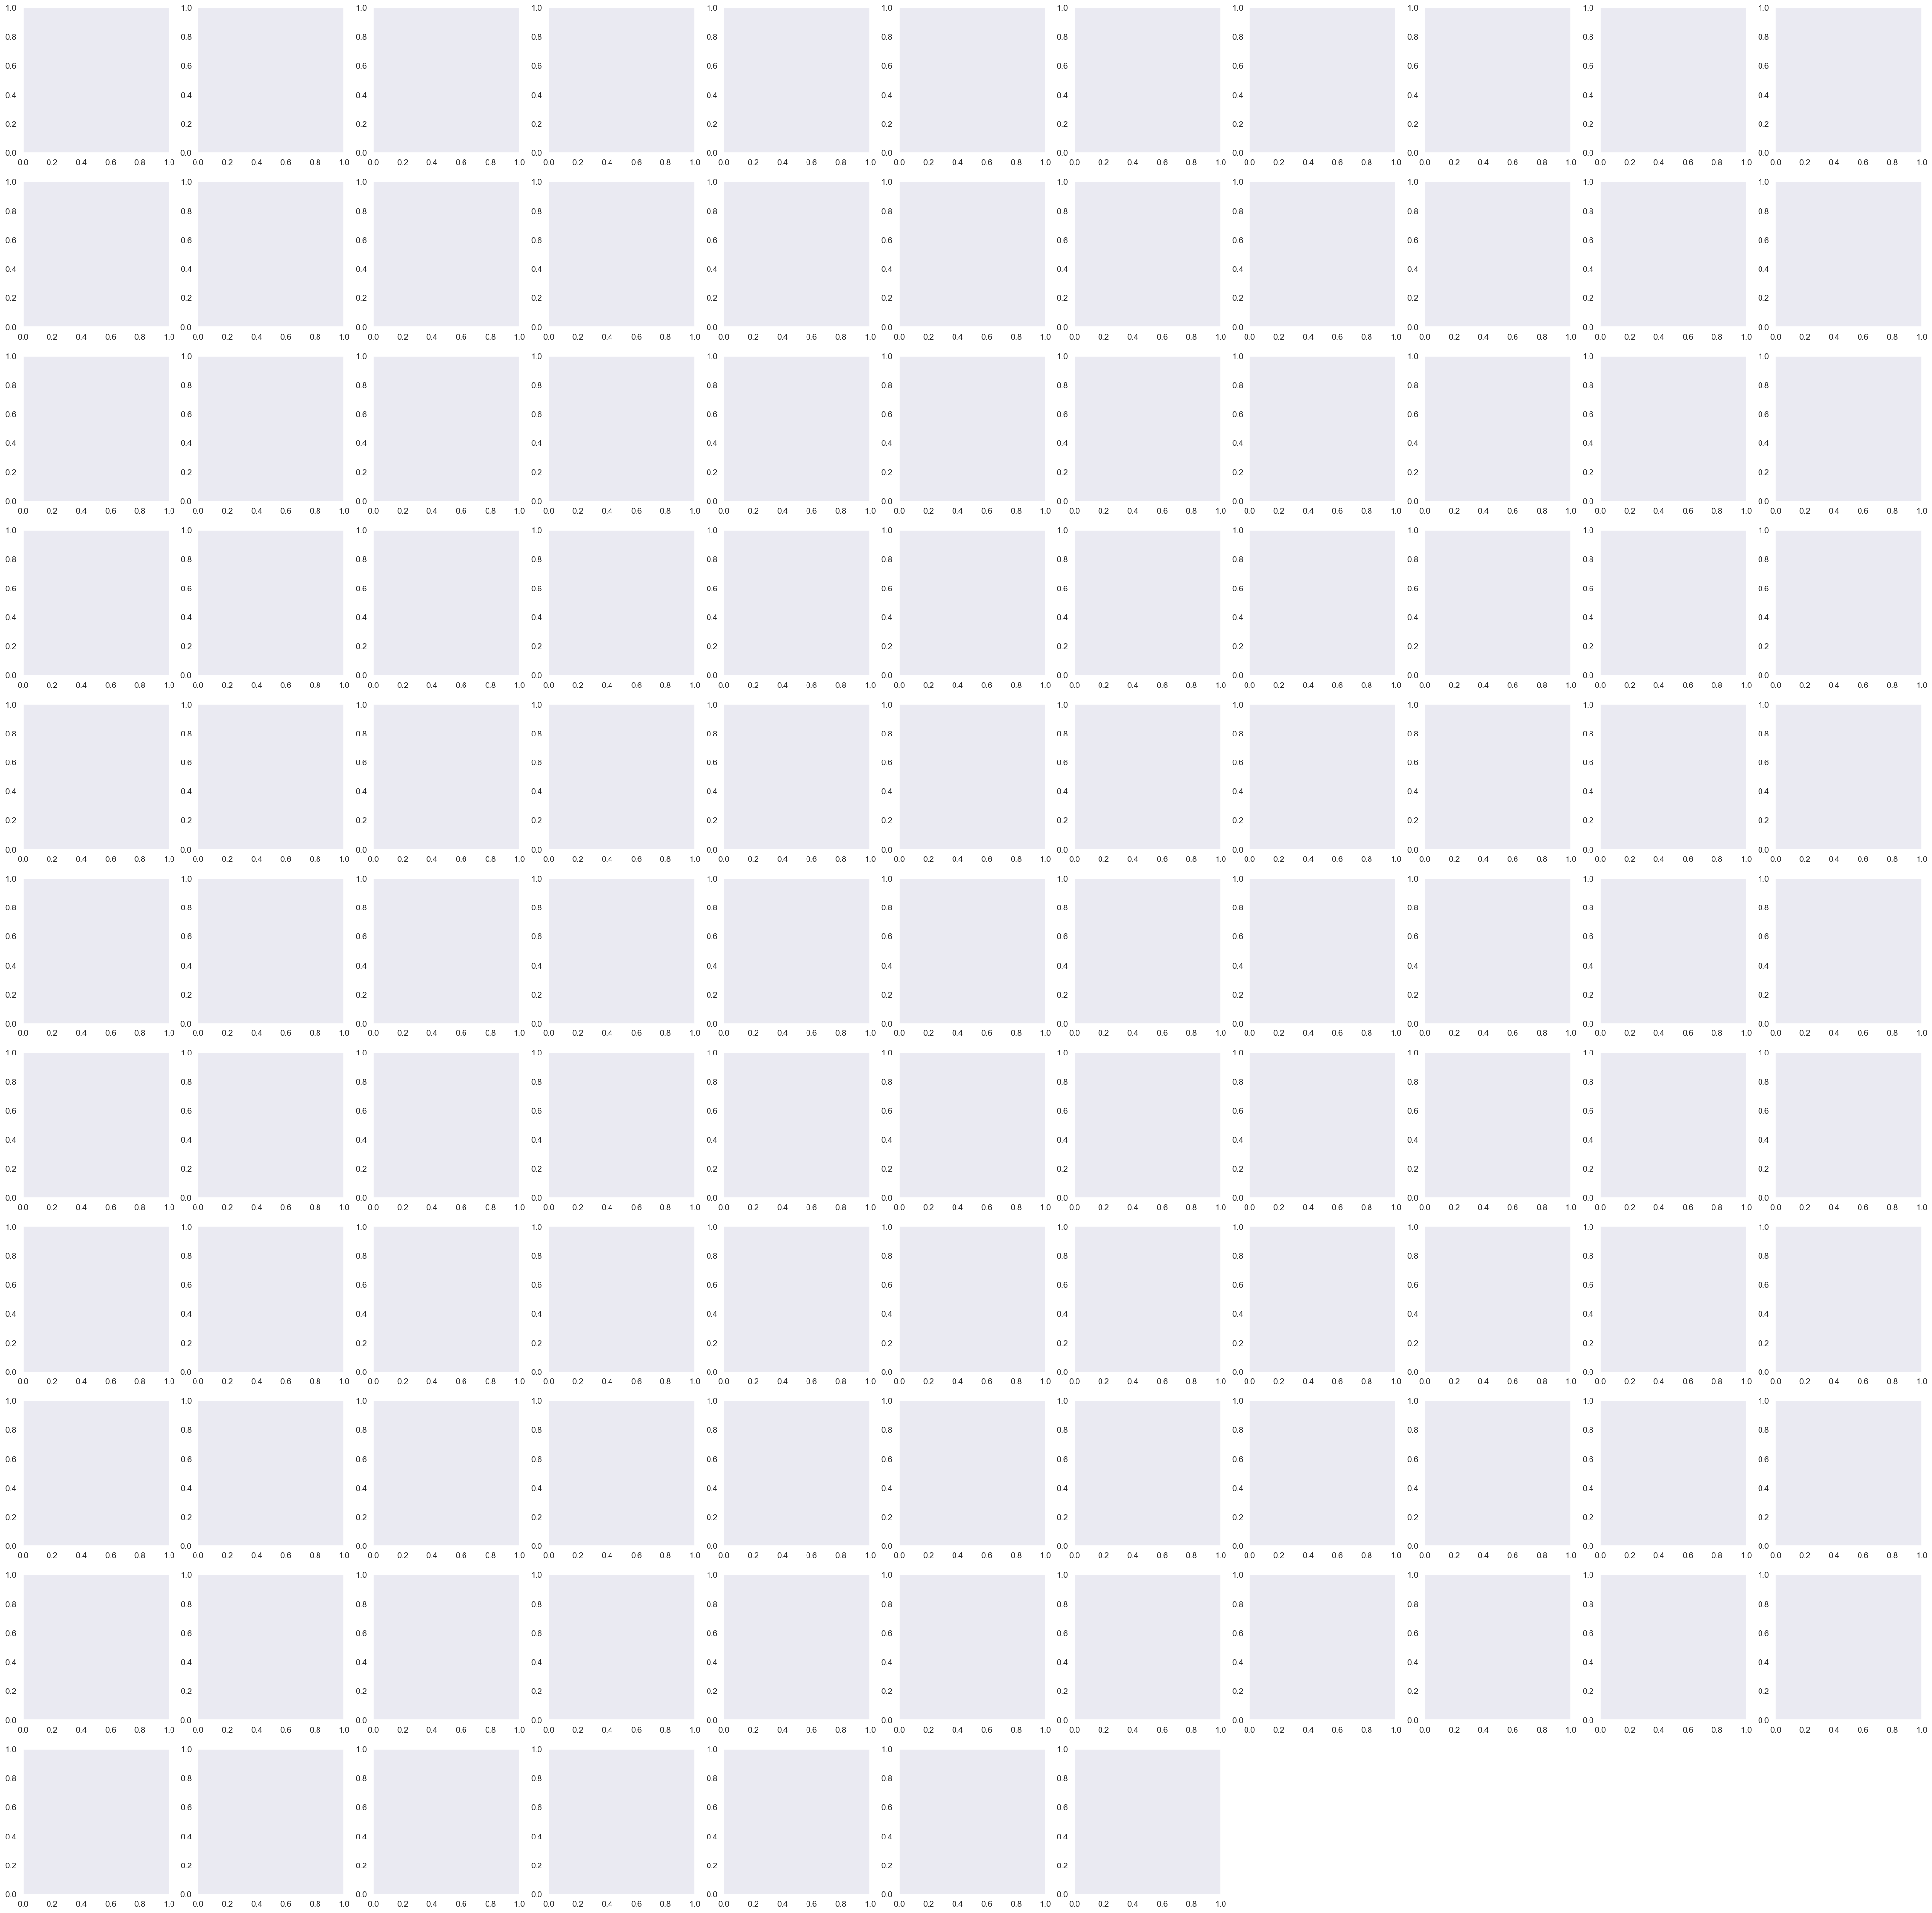

In [13]:
fig, axes = plt.subplots(11,11, figsize=(50,50))

for i in range(11**2):
    row = i // 11
    col = i % 11
    ax = axes[row, col]
    row_p = list(param_space.keys())[row]
    col_p = list(param_space.keys())[col]
    
    if row == col:
        sns.scatterplot(data=ml_history_df, x=col_p, y='mean_loss', ax=ax, color=PAL[i % len(PAL)])
        ax2 = ax.twinx()
        sns.kdeplot(data=ml_history_df, x=col_p, ax=ax2, color=PAL[i % len(PAL)], cut=True, alpha=0.6)
        ax.set_ylabel('Mean Loss')
        ax.set_xlabel(param_names[col])
        ax.set_title(f'{param_names[col]} vs Loss (left axis)\nAnd sampled density (right axis)')
    else:
        sns.scatterplot(data=ml_history_df, x=col_p, y=row_p, hue='mean_loss', ax=ax, palette='viridis')
        sns.kdeplot(data=ml_history_df, x=col_p, y=row_p, fill=False, ax=ax, cut=True, alpha=0.4, color=PAL[i % len(PAL)])
        ax.set_ylabel(param_names[row])
        ax.set_xlabel(param_names[col])
        ax.get_legend().remove()
# for i, p in enumerate(param_names):
#     axes[i, 0].set_ylabel(p)
#     axes[0, i].set_title(p)

plt.tight_layout()
plt.savefig(os.path.join(PLOTS, 'base_ml_model_frace.png'), bbox_to_inches='tight')
plt.show()

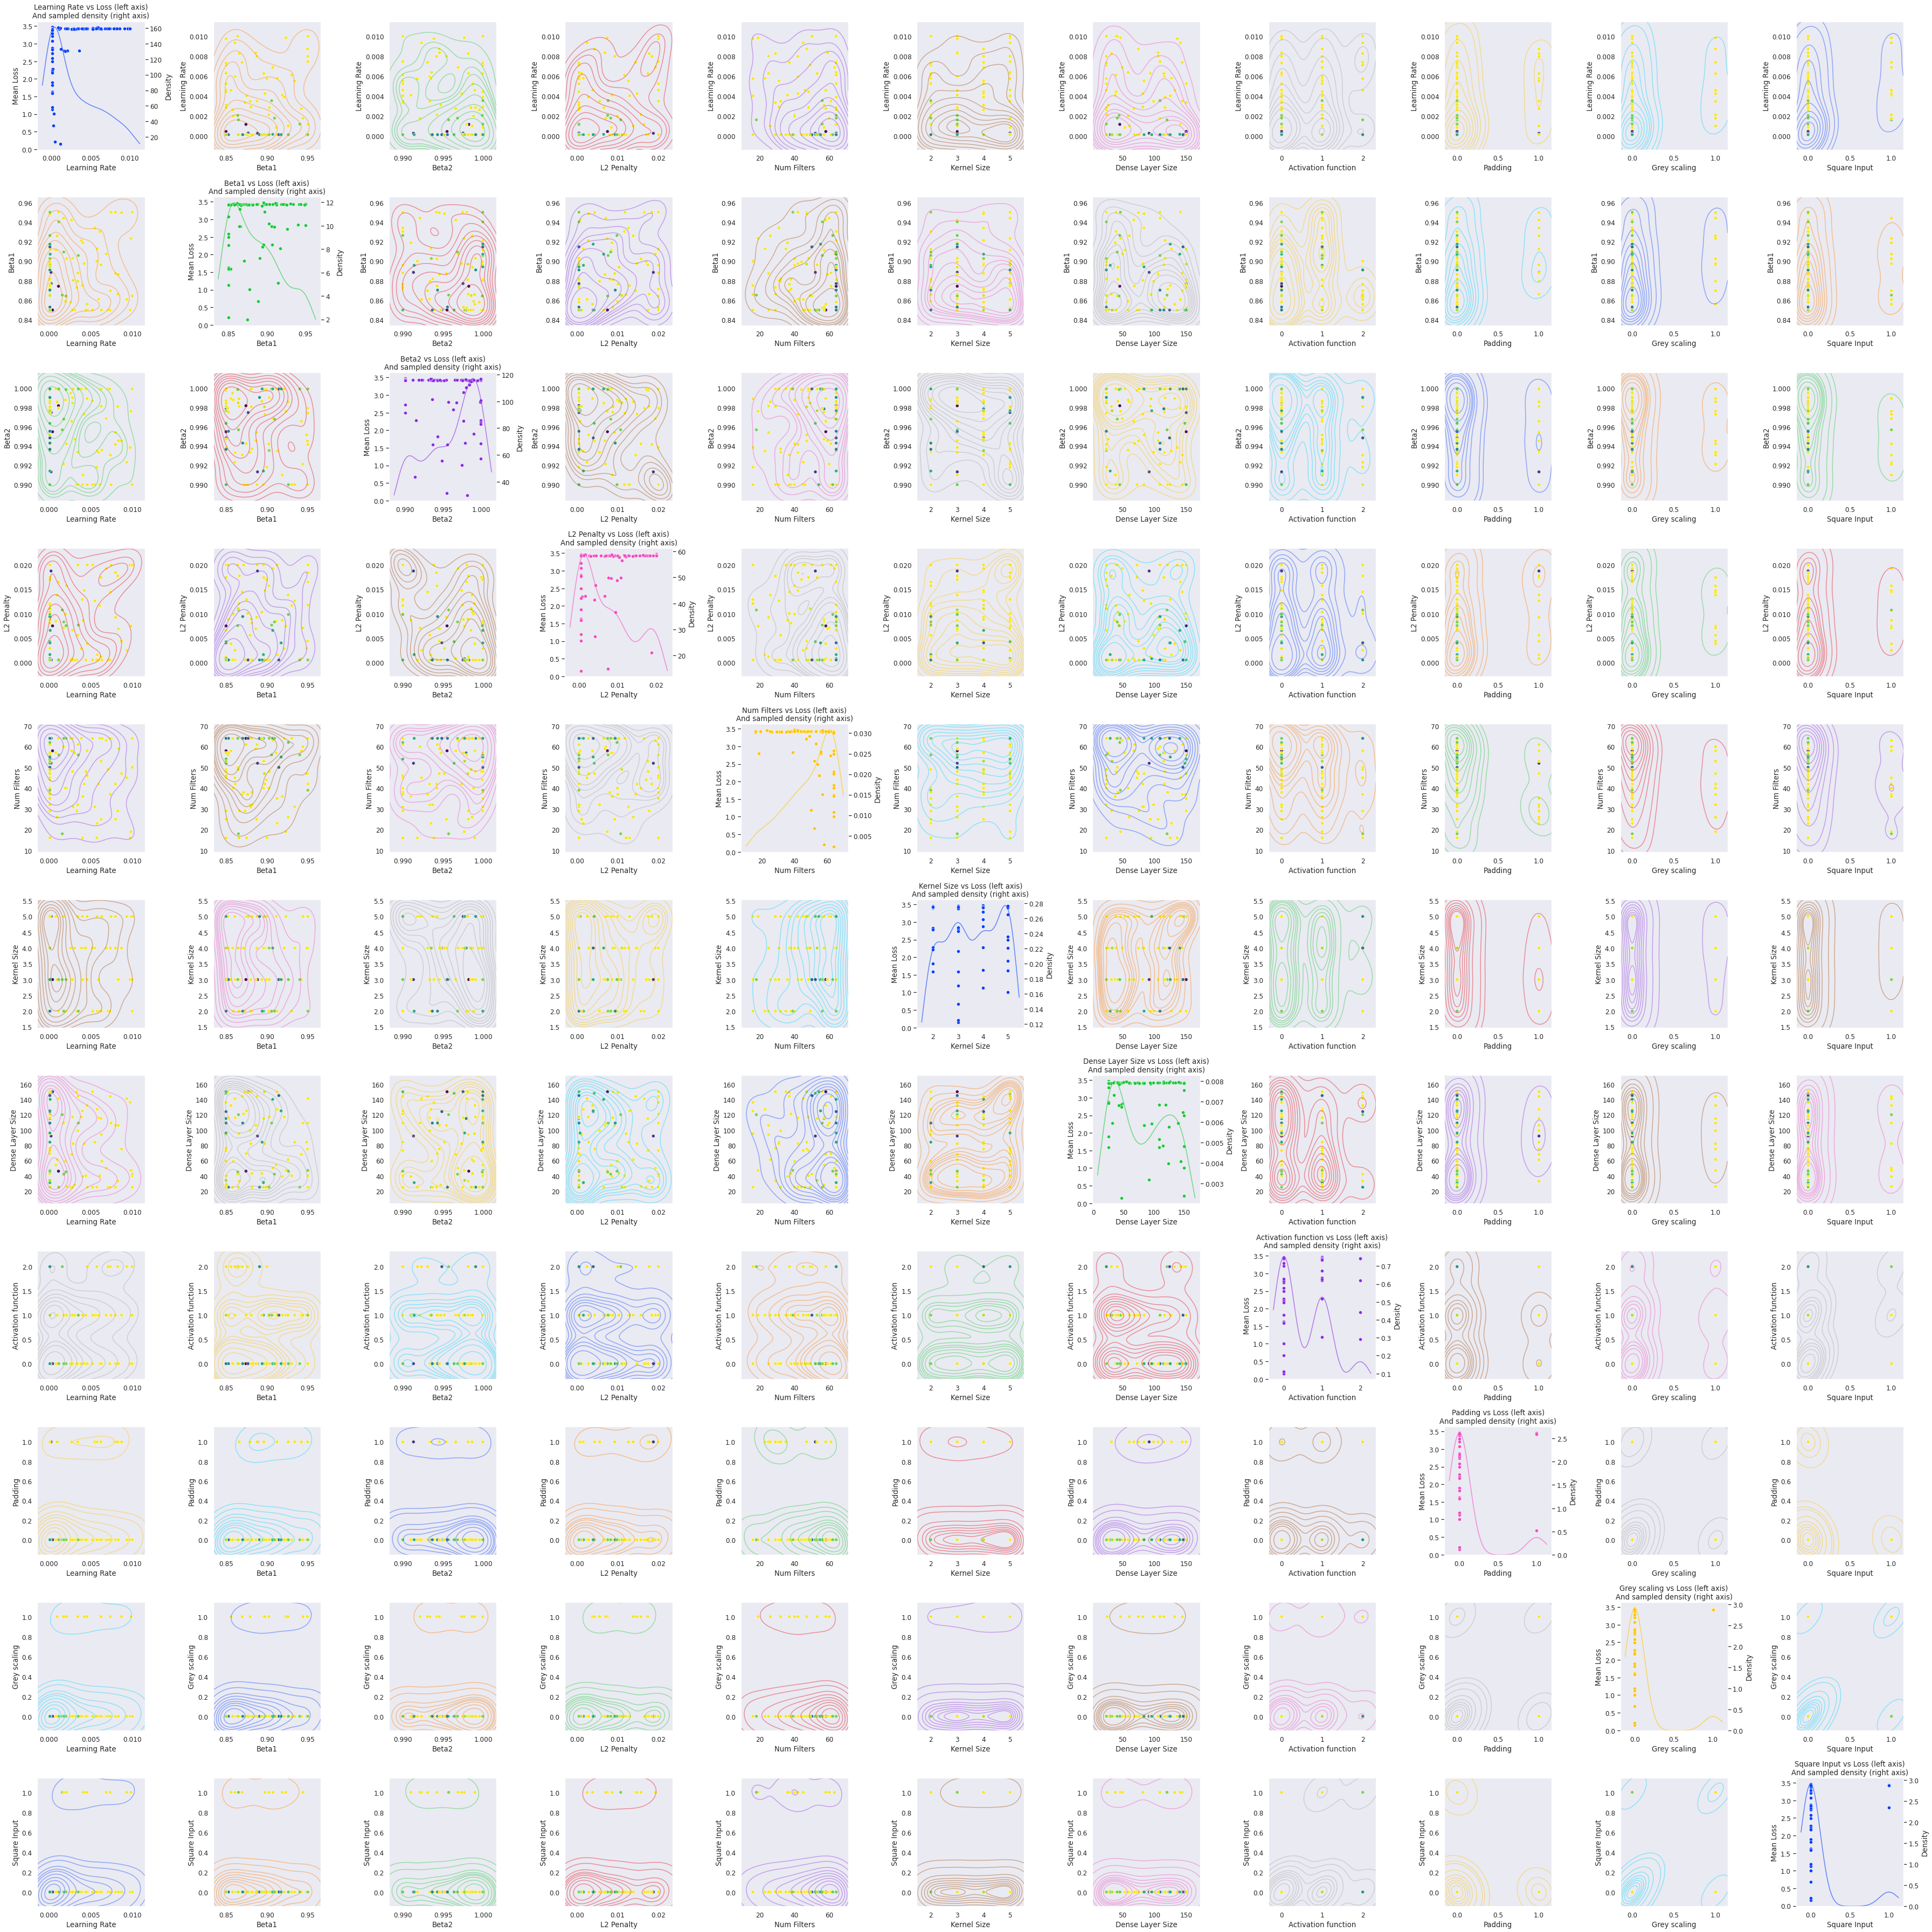

In [ ]:
fig, axes = plt.subplots(11,11, figsize=(50,50))

for i in range(11**2):
    row = i // 11
    col = i % 11
    ax = axes[row, col]
    row_p = list(param_space.keys())[row]
    col_p = list(param_space.keys())[col]
    
    if row == col:
        sns.scatterplot(data=mc_history_df, x=col_p, y='mean_loss', ax=ax, color=PAL[i % len(PAL)])
        ax2 = ax.twinx()
        sns.kdeplot(data=mc_history_df, x=col_p, ax=ax2, color=PAL[i % len(PAL)], cut=True, alpha=0.6)
        ax.set_ylabel('Mean Loss')
        ax.set_xlabel(param_names[col])
        ax.set_title(f'{param_names[col]} vs Loss (left axis)\nAnd sampled density (right axis)')
    else:
        sns.scatterplot(data=mc_history_df, x=col_p, y=row_p, hue='mean_loss', ax=ax, palette='viridis')
        sns.kdeplot(data=mc_history_df, x=col_p, y=row_p, fill=False, ax=ax, cut=True, alpha=0.4, color=PAL[i % len(PAL)])
        ax.set_ylabel(param_names[row])
        ax.set_xlabel(param_names[col])
        ax.get_legend().remove()

# for i, p in enumerate(param_names):
#     axes[i, 0].set_ylabel(p)
#     axes[0, i].set_title(p)

plt.tight_layout()
plt.savefig(os.path.join(PLOTS, 'base_mc_model_frace.png'), bbox_to_inches='tight')
plt.show()

Notes
Iteration 1: 10600s = 2h55m
Iteration 2: 8600s = 2h23m
Iteration 3: 9100 = 2h41m
Iteration 4: 8900 = 2h28m
Iteration 5: 9500 = 2h38m

TOTAL: 46772s = 13h

In [14]:
from sklearn.decomposition import PCA, SparsePCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from scipy.stats.qmc import Sobol

In [18]:
D = len(param_space)
M = int(np.ceil(np.log2(1000)))
SAMPLER = Sobol(d=D)
_ = SAMPLER.fast_forward(2 ** M)
sample_params = []
int_idx = 4

points = SAMPLER.random_base2(m=M)
for i, sample in enumerate(points):
    params = [p * (ub - lb) + lb for p, (lb, ub) in zip(sample, param_space.values())]
    params = [p if idx < int_idx else round(p) for idx, p in enumerate(params)]
    sample_params.append(params)
sample_params = np.array(sample_params)
sample_params.shape

(1024, 11)

In [25]:
SS = StandardScaler()
sample_params_scaled = SS.fit_transform(sample_params)

pca = PCA(n_components=2)
pca.fit(sample_params_scaled)
sample_params_pca = pca.transform(sample_params_scaled)

In [34]:
from openTSNE import TSNE

In [37]:
tsne = TSNE(n_components=2, random_state=42)
sample_params_tsne = tsne.fit(sample_params_scaled)

In [22]:
ml_hist_x = ml_history_df[param_space.keys()]
ml_hist_y = ml_history_df['mean_loss']

ml_hist_x_scaled = SS.transform(ml_hist_x)

In [40]:

ml_hist_x_pca = pca.transform(ml_hist_x_scaled)
ml_hist_x_tsne = sample_params_tsne.transform(ml_hist_x_scaled)
print('Fraction explained variance:', sum(pca.explained_variance_ratio_))

Fraction explained variance: 0.18261935236086435


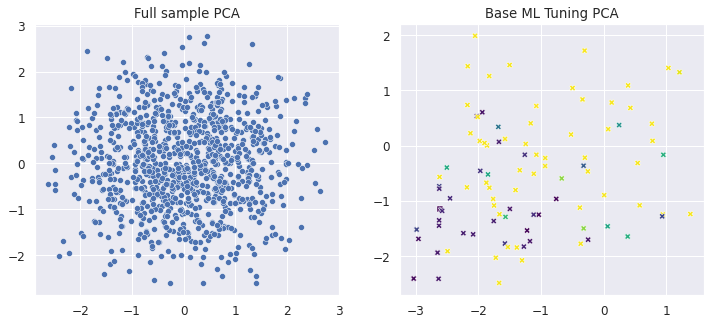

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(x=sample_params_pca[:, 0], y=sample_params_pca[:, 1], ax=axes[0])
axes[0].set_title('Full sample PCA')

sns.scatterplot(x=ml_hist_x_pca[:, 0], y=ml_hist_x_pca[:, 1], style=ml_history_df.index == ml_highest, markers=['X', 's'], hue=ml_hist_y, palette='viridis', ax=axes[1])
axes[1].set_title('Base ML Tuning PCA')

axes[1].get_legend().remove()

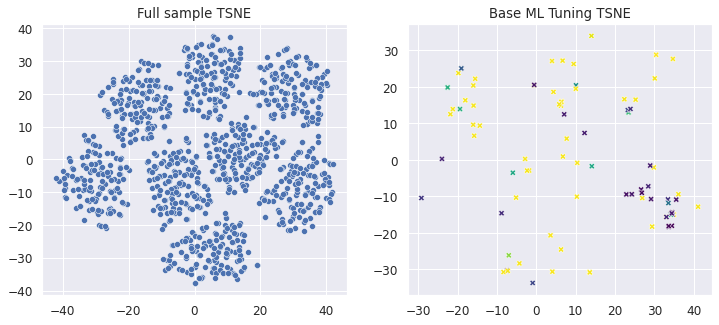

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(x=sample_params_tsne[:, 0], y=sample_params_tsne[:, 1], ax=axes[0])
axes[0].set_title('Full sample TSNE')

sns.scatterplot(x=ml_hist_x_tsne[:, 0], y=ml_hist_x_tsne[:, 1], style=ml_history_df.index == ml_highest, markers=['X', 's'], hue=ml_hist_y, palette='viridis', ax=axes[1])
axes[1].set_title('Base ML Tuning TSNE')

axes[1].get_legend().remove()

In [28]:
spca = SparsePCA(n_components=2)
spca.fit(sample_params_scaled)
P = spca.components_.T  # loadings
sample_params_spca = spca.transform(sample_params_scaled)  # score
Xc = sample_params_scaled - sample_params_scaled.mean(axis=0)  # center data

explained_variance = np.trace(P @ sample_params_spca.T @ sample_params_spca @ P.T)
total_variance = np.trace(Xc.T @ Xc)
print('Fraction explained variance:', explained_variance / total_variance)

Fraction explained variance: 0.17823564534671332


In [29]:
kpca = KernelPCA(n_components=2, kernel='rbf')
kpca.fit(sample_params_scaled)
sample_params_kpca = kpca.transform(sample_params_scaled)

Text(0.5, 1.0, 'Kernel PCA')

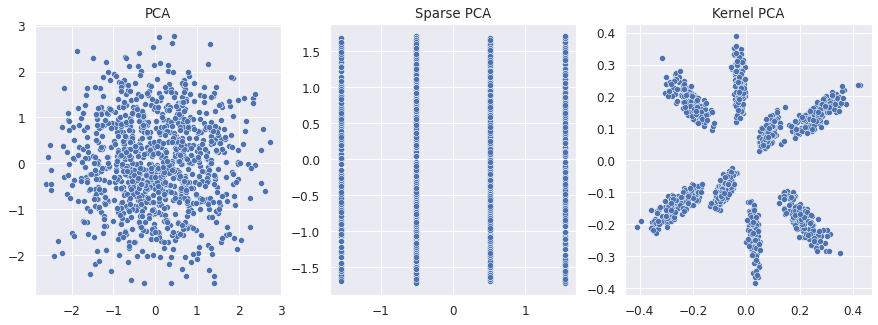

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.scatterplot(x=sample_params_pca[:, 0], y=sample_params_pca[:, 1], ax=axes[0])
axes[0].set_title('PCA')

sns.scatterplot(x=sample_params_spca[:, 0], y=sample_params_spca[:, 1], ax=axes[1])
axes[1].set_title('Sparse PCA')

sns.scatterplot(x=sample_params_kpca[:, 0], y=sample_params_kpca[:, 1], ax=axes[2])
axes[2].set_title('Kernel PCA')

# axes[0].get_legend().remove()
# axes[1].get_legend().remove()
# axes[2].get_legend().remove()

In [18]:
mc_hist_x = mc_history_df[param_space.keys()]
mc_hist_y = mc_history_df['mean_loss']

SS = StandardScaler()
mc_hist_x_scaled = SS.fit_transform(mc_hist_x)

In [19]:
pca = PCA(n_components=2)
pca.fit(mc_hist_x_scaled)

mc_hist_x_pca = pca.transform(mc_hist_x_scaled)
print('Fraction explained variance:', sum(pca.explained_variance_ratio_))

Fraction explained variance: 0.3413678408969356


In [20]:
spca = SparsePCA(n_components=2)
spca.fit(mc_hist_x_scaled)
P = spca.components_.T  # loadings
mc_hist_x_spca = spca.transform(mc_hist_x_scaled)  # score
Xc = mc_hist_x_scaled - mc_hist_x_scaled.mean(axis=0)  # center data

explained_variance = np.trace(P @ mc_hist_x_spca.T @ mc_hist_x_spca @ P.T)
total_variance = np.trace(Xc.T @ Xc)
print('Fraction explained variance:', explained_variance / total_variance)

Fraction explained variance: 0.3297976915120315


In [21]:
kpca = KernelPCA(n_components=2, kernel='rbf')
kpca.fit(mc_hist_x_scaled)
mc_hist_x_kpca = kpca.transform(mc_hist_x_scaled)

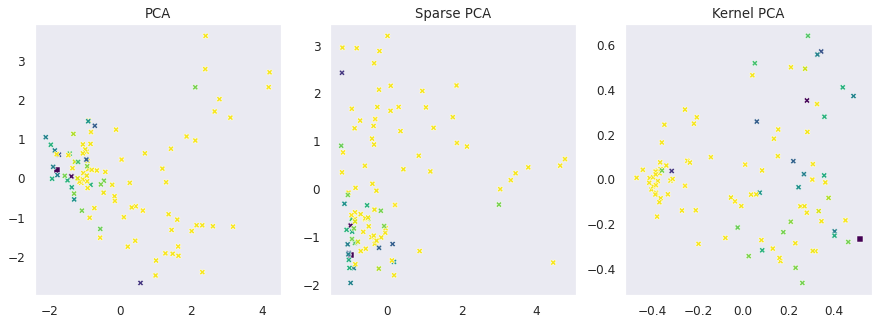

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.scatterplot(x=mc_hist_x_pca[:, 0], y=mc_hist_x_pca[:, 1], hue=mc_hist_y, style=mc_history_df.index == mc_highest, markers=['X', 's'], palette='viridis', ax=axes[0])
axes[0].set_title('PCA')

sns.scatterplot(x=mc_hist_x_spca[:, 0], y=mc_hist_x_spca[:, 1], hue=mc_hist_y, style=mc_history_df.index == mc_highest, markers=['X', 's'], palette='viridis', ax=axes[1])
axes[1].set_title('Sparse PCA')

sns.scatterplot(x=mc_hist_x_kpca[:, 0], y=mc_hist_x_kpca[:, 1], hue=mc_hist_y, style=mc_history_df.index == mc_highest, markers=['X', 's'], palette='viridis', ax=axes[2])
axes[2].set_title('Kernel PCA')

axes[0].get_legend().remove()
axes[1].get_legend().remove()
axes[2].get_legend().remove()

## Model re-training and evaluation

In [13]:
DEV = 'cpu'

In [14]:
ml_elite_params = {key: val for key, val in zip(param_names, ml_elite_result['model_configs'][ml_highest])}
mc_elite_params = {key: val for key, val in zip(param_names, mc_elite_result['model_configs'][mc_highest])}
param_names

['Learning Rate',
 'Beta1',
 'Beta2',
 'L2 Penalty',
 'Num Filters',
 'Kernel Size',
 'Dense Layer Size',
 'Activation function',
 'Padding',
 'Grey scaling',
 'Square Input']

In [15]:
ml_train_loader = myDataLoader(train_X, train_Y, batch_sz=2048)
ml_val_loader = myDataLoader(val_X, val_Y, batch_sz=2048)

mc_train_loader = myDataLoader(train_X, train_Y_cat, batch_sz=2048)
mc_val_loader = myDataLoader(val_X, val_Y_cat, batch_sz=2048)

### Training

In [15]:
ml_size = train_X[0].shape
if ml_elite_params['Grey scaling']:
    ml_size = (ml_size[0], ml_size[1], 1)
if ml_elite_params['Square Input']:
    ml_size = (32, 32, ml_size[2])

ml_model = ModelWrapper(in_size=ml_size, filts=ml_elite_params['Num Filters'], kerns=ml_elite_params['Kernel Size'], pad=ml_elite_params['Padding'],
                        out_size=6, activ=activations[ml_elite_params['Activation function']], dense_sz=ml_elite_params['Dense Layer Size'],
                        beta_1=ml_elite_params['Beta1'], beta_2=ml_elite_params['Beta2'], lr=ml_elite_params['Learning Rate'], l2=ml_elite_params['L2 Penalty'],
                        grey_scaled=ml_elite_params['Grey scaling'], square_in=ml_elite_params['Square Input'], dev=DEV)

In [29]:
ml_model_hist = ml_model.train(ml_train_loader, ml_val_loader, epochs=100, patience=2, verbose=2)
ml_model.save(os.path.join(MODEL_PATH, 'base_ml_model_v2'))

Re-evaluating model on Train set: 100%|██████████| 34/34 [00:01<00:00, 23.19it/s]


E0, train loss: 0.405, val loss: 0.410 -- train acc: 0.8521, val acc: 0.8477
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:01<00:00, 20.99it/s]


E1, train loss: 0.147, val loss: 0.155 -- train acc: 0.9660, val acc: 0.9580
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:01<00:00, 19.84it/s]


E2, train loss: 0.094, val loss: 0.096 -- train acc: 0.9798, val acc: 0.9796
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 13.07it/s]


E3, train loss: 0.080, val loss: 0.086 -- train acc: 0.9813, val acc: 0.9783
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:01<00:00, 18.02it/s]


E4, train loss: 0.059, val loss: 0.057 -- train acc: 0.9886, val acc: 0.9895
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:01<00:00, 21.20it/s]


E5, train loss: 0.048, val loss: 0.046 -- train acc: 0.9907, val acc: 0.9920
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 13.43it/s]


E6, train loss: 0.036, val loss: 0.035 -- train acc: 0.9930, val acc: 0.9938
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 14.44it/s]


E7, train loss: 0.034, val loss: 0.033 -- train acc: 0.9935, val acc: 0.9937
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 14.29it/s]


E8, train loss: 0.031, val loss: 0.029 -- train acc: 0.9943, val acc: 0.9956
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:01<00:00, 20.69it/s]


E9, train loss: 0.029, val loss: 0.028 -- train acc: 0.9940, val acc: 0.9940
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:01<00:00, 17.75it/s]


E10, train loss: 0.026, val loss: 0.026 -- train acc: 0.9942, val acc: 0.9942
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 16.20it/s]


E11, train loss: 0.024, val loss: 0.022 -- train acc: 0.9955, val acc: 0.9963
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 16.72it/s]


E12, train loss: 0.021, val loss: 0.020 -- train acc: 0.9962, val acc: 0.9967
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 14.59it/s]


E13, train loss: 0.020, val loss: 0.019 -- train acc: 0.9961, val acc: 0.9969
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:01<00:00, 18.83it/s]


E14, train loss: 0.019, val loss: 0.018 -- train acc: 0.9962, val acc: 0.9969
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:01<00:00, 17.68it/s]


E15, train loss: 0.019, val loss: 0.018 -- train acc: 0.9964, val acc: 0.9970
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 14.50it/s]


E16, train loss: 0.018, val loss: 0.017 -- train acc: 0.9965, val acc: 0.9973
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 13.65it/s]


E17, train loss: 0.018, val loss: 0.017 -- train acc: 0.9964, val acc: 0.9972
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 16.69it/s]


E18, train loss: 0.017, val loss: 0.016 -- train acc: 0.9965, val acc: 0.9973
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:01<00:00, 20.90it/s]


E19, train loss: 0.018, val loss: 0.016 -- train acc: 0.9962, val acc: 0.9968
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 16.89it/s]


E20, train loss: 0.016, val loss: 0.015 -- train acc: 0.9969, val acc: 0.9973
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:01<00:00, 21.08it/s]


E21, train loss: 0.017, val loss: 0.016 -- train acc: 0.9967, val acc: 0.9973
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:01<00:00, 19.25it/s]


E22, train loss: 0.015, val loss: 0.014 -- train acc: 0.9968, val acc: 0.9977
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 14.09it/s]


E23, train loss: 0.015, val loss: 0.014 -- train acc: 0.9967, val acc: 0.9974
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 14.35it/s]


E24, train loss: 0.015, val loss: 0.015 -- train acc: 0.9967, val acc: 0.9971
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:01<00:00, 19.82it/s]


E25, train loss: 0.015, val loss: 0.014 -- train acc: 0.9970, val acc: 0.9976
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:01<00:00, 18.69it/s]


E26, train loss: 0.015, val loss: 0.014 -- train acc: 0.9969, val acc: 0.9978
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:01<00:00, 18.53it/s]


E27, train loss: 0.014, val loss: 0.013 -- train acc: 0.9971, val acc: 0.9978
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:01<00:00, 21.18it/s]


E28, train loss: 0.013, val loss: 0.013 -- train acc: 0.9971, val acc: 0.9976
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 13.55it/s]


E29, train loss: 0.014, val loss: 0.013 -- train acc: 0.9971, val acc: 0.9976
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 14.03it/s]


E30, train loss: 0.012, val loss: 0.012 -- train acc: 0.9975, val acc: 0.9980
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:01<00:00, 21.20it/s]


E31, train loss: 0.014, val loss: 0.013 -- train acc: 0.9971, val acc: 0.9977
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:01<00:00, 21.16it/s]


E32, train loss: 0.013, val loss: 0.012 -- train acc: 0.9970, val acc: 0.9974
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 16.18it/s]


E33, train loss: 0.014, val loss: 0.014 -- train acc: 0.9968, val acc: 0.9970
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:01<00:00, 21.46it/s]


E34, train loss: 0.013, val loss: 0.012 -- train acc: 0.9972, val acc: 0.9978
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:01<00:00, 21.11it/s]


E35, train loss: 0.013, val loss: 0.012 -- train acc: 0.9970, val acc: 0.9975
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 13.99it/s]


E36, train loss: 0.016, val loss: 0.015 -- train acc: 0.9965, val acc: 0.9969
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 13.55it/s]


E37, train loss: 0.014, val loss: 0.012 -- train acc: 0.9967, val acc: 0.9976
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 14.30it/s]


E38, train loss: 0.012, val loss: 0.011 -- train acc: 0.9973, val acc: 0.9977
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 14.39it/s]


E39, train loss: 0.013, val loss: 0.013 -- train acc: 0.9971, val acc: 0.9976
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 13.88it/s]


E40, train loss: 0.013, val loss: 0.012 -- train acc: 0.9969, val acc: 0.9976
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 14.19it/s]


E41, train loss: 0.012, val loss: 0.012 -- train acc: 0.9974, val acc: 0.9975
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 13.63it/s]


E42, train loss: 0.013, val loss: 0.012 -- train acc: 0.9972, val acc: 0.9977
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:01<00:00, 21.23it/s]


E43, train loss: 0.011, val loss: 0.010 -- train acc: 0.9975, val acc: 0.9978
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:01<00:00, 21.09it/s]


E44, train loss: 0.011, val loss: 0.011 -- train acc: 0.9975, val acc: 0.9979
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 13.62it/s]


E45, train loss: 0.012, val loss: 0.012 -- train acc: 0.9976, val acc: 0.9979
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:01<00:00, 20.18it/s]


E46, train loss: 0.011, val loss: 0.010 -- train acc: 0.9975, val acc: 0.9980
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:01<00:00, 21.42it/s]


E47, train loss: 0.012, val loss: 0.011 -- train acc: 0.9976, val acc: 0.9981
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:01<00:00, 19.46it/s]


E48, train loss: 0.012, val loss: 0.010 -- train acc: 0.9974, val acc: 0.9978
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:01<00:00, 20.91it/s]


E49, train loss: 0.011, val loss: 0.011 -- train acc: 0.9975, val acc: 0.9979
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 14.00it/s]


E50, train loss: 0.012, val loss: 0.011 -- train acc: 0.9977, val acc: 0.9980
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:01<00:00, 21.00it/s]


E51, train loss: 0.011, val loss: 0.010 -- train acc: 0.9974, val acc: 0.9979
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 14.55it/s]


E52, train loss: 0.011, val loss: 0.011 -- train acc: 0.9975, val acc: 0.9978
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 15.80it/s]


E53, train loss: 0.012, val loss: 0.011 -- train acc: 0.9971, val acc: 0.9975
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:01<00:00, 21.11it/s]


E54, train loss: 0.012, val loss: 0.011 -- train acc: 0.9971, val acc: 0.9975
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:01<00:00, 21.12it/s]


E55, train loss: 0.013, val loss: 0.013 -- train acc: 0.9972, val acc: 0.9966
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 15.00it/s]


E56, train loss: 0.012, val loss: 0.010 -- train acc: 0.9974, val acc: 0.9979
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 13.97it/s]


E57, train loss: 0.011, val loss: 0.010 -- train acc: 0.9978, val acc: 0.9980
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:01<00:00, 17.05it/s]


E58, train loss: 0.010, val loss: 0.009 -- train acc: 0.9976, val acc: 0.9981
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:01<00:00, 21.06it/s]


E59, train loss: 0.010, val loss: 0.009 -- train acc: 0.9979, val acc: 0.9982
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:01<00:00, 20.85it/s]


E60, train loss: 0.010, val loss: 0.010 -- train acc: 0.9978, val acc: 0.9981
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:01<00:00, 20.03it/s]


E61, train loss: 0.011, val loss: 0.010 -- train acc: 0.9977, val acc: 0.9981
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 13.55it/s]


E62, train loss: 0.012, val loss: 0.010 -- train acc: 0.9973, val acc: 0.9981
Saving history state...


In [16]:
mc_size = train_X[0].shape
if mc_elite_params['Grey scaling']:
    mc_size = (mc_size[0], mc_size[1], 1)
if mc_elite_params['Square Input']:
    mc_size = (32, 32, mc_size[2])

mc_model = ModelWrapper(in_size=mc_size, filts=mc_elite_params['Num Filters'], kerns=mc_elite_params['Kernel Size'], pad=mc_elite_params['Padding'],
                        out_size=64, activ=activations[mc_elite_params['Activation function']], dense_sz=mc_elite_params['Dense Layer Size'],
                        beta_1=mc_elite_params['Beta1'], beta_2=mc_elite_params['Beta2'], lr=mc_elite_params['Learning Rate'], l2=mc_elite_params['L2 Penalty'],
                        grey_scaled=mc_elite_params['Grey scaling'], square_in=mc_elite_params['Square Input'], dev=DEV)

In [17]:
mc_model_hist = mc_model.train(mc_train_loader, mc_val_loader, epochs=100, patience=2, verbose=2)
mc_model.save(os.path.join(MODEL_PATH, 'base_mc_model_v2'))

Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 11.86it/s]


E0, train loss: 3.457, val loss: 3.459 -- train acc: 0.5602, val acc: 0.5591
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 11.60it/s]


E1, train loss: 3.439, val loss: 3.434 -- train acc: 0.5889, val acc: 0.5870
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 11.77it/s]


E2, train loss: 3.426, val loss: 3.419 -- train acc: 0.7139, val acc: 0.7054
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 11.75it/s]


E3, train loss: 3.402, val loss: 3.397 -- train acc: 0.6858, val acc: 0.6837
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:03<00:00, 11.00it/s]


E4, train loss: 2.549, val loss: 2.584 -- train acc: 0.8396, val acc: 0.8349
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 11.48it/s]


E5, train loss: 0.815, val loss: 0.856 -- train acc: 0.9523, val acc: 0.9497
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 11.43it/s]


E6, train loss: 0.529, val loss: 0.501 -- train acc: 0.9709, val acc: 0.9666
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:03<00:00, 11.03it/s]


E7, train loss: 0.434, val loss: 0.446 -- train acc: 0.9757, val acc: 0.9736
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 11.82it/s]


E8, train loss: 0.376, val loss: 0.429 -- train acc: 0.9755, val acc: 0.9650
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 11.64it/s]


E9, train loss: 0.281, val loss: 0.343 -- train acc: 0.9840, val acc: 0.9791
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:03<00:00, 11.05it/s]


E10, train loss: 0.310, val loss: 0.392 -- train acc: 0.9799, val acc: 0.9686
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 11.38it/s]


E11, train loss: 0.269, val loss: 0.356 -- train acc: 0.9822, val acc: 0.9705
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 11.43it/s]


E12, train loss: 0.252, val loss: 0.331 -- train acc: 0.9839, val acc: 0.9743
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 11.68it/s]


E13, train loss: 0.234, val loss: 0.315 -- train acc: 0.9848, val acc: 0.9758
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 11.74it/s]


E14, train loss: 0.201, val loss: 0.240 -- train acc: 0.9871, val acc: 0.9839
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 11.68it/s]


E15, train loss: 0.168, val loss: 0.171 -- train acc: 0.9899, val acc: 0.9902
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 11.42it/s]


E16, train loss: 0.180, val loss: 0.167 -- train acc: 0.9886, val acc: 0.9896
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:03<00:00, 11.31it/s]


E17, train loss: 0.138, val loss: 0.128 -- train acc: 0.9921, val acc: 0.9932
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 11.44it/s]


E18, train loss: 0.142, val loss: 0.129 -- train acc: 0.9910, val acc: 0.9917
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 11.74it/s]


E19, train loss: 0.134, val loss: 0.128 -- train acc: 0.9921, val acc: 0.9927
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 11.63it/s]


E20, train loss: 0.160, val loss: 0.192 -- train acc: 0.9893, val acc: 0.9859
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 11.71it/s]


E21, train loss: 0.159, val loss: 0.192 -- train acc: 0.9903, val acc: 0.9889
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 11.37it/s]


E22, train loss: 0.182, val loss: 0.178 -- train acc: 0.9878, val acc: 0.9864
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 11.42it/s]


E23, train loss: 0.121, val loss: 0.118 -- train acc: 0.9925, val acc: 0.9933
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:03<00:00, 11.15it/s]


E24, train loss: 0.121, val loss: 0.135 -- train acc: 0.9925, val acc: 0.9920
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 11.42it/s]


E25, train loss: 0.136, val loss: 0.181 -- train acc: 0.9914, val acc: 0.9887
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 11.68it/s]


E26, train loss: 0.104, val loss: 0.099 -- train acc: 0.9938, val acc: 0.9946
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:03<00:00, 11.05it/s]


E27, train loss: 0.143, val loss: 0.164 -- train acc: 0.9903, val acc: 0.9874
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 11.74it/s]


E28, train loss: 0.108, val loss: 0.103 -- train acc: 0.9936, val acc: 0.9942
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 11.36it/s]


E29, train loss: 0.106, val loss: 0.114 -- train acc: 0.9935, val acc: 0.9934
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:03<00:00, 10.63it/s]


E30, train loss: 0.118, val loss: 0.115 -- train acc: 0.9930, val acc: 0.9933
Saving history state...


Re-evaluating model on Train set: 100%|██████████| 34/34 [00:02<00:00, 11.49it/s]


E31, train loss: 0.147, val loss: 0.150 -- train acc: 0.9904, val acc: 0.9890
Saving history state...


### Reloading

In [16]:
ml_model = ModelWrapper(dev=DEV)
ml_model.load(os.path.join(MODEL_PATH, 'base_ml_model_v2'))
ml_model_hist = ml_model.history

mc_model = ModelWrapper(dev=DEV)
mc_model.load(os.path.join(MODEL_PATH, 'base_mc_model_v2'))
mc_model_hist = mc_model.history

In [17]:
print(f"ml_model convergence epoch: {ml_model.conv_epoch} / {ml_model.trained_epochs}; mc_model convergence epoch: {mc_model.conv_epoch} / {mc_model.trained_epochs}")

ml_model convergence epoch: 59 / 63; mc_model convergence epoch: 26 / 32


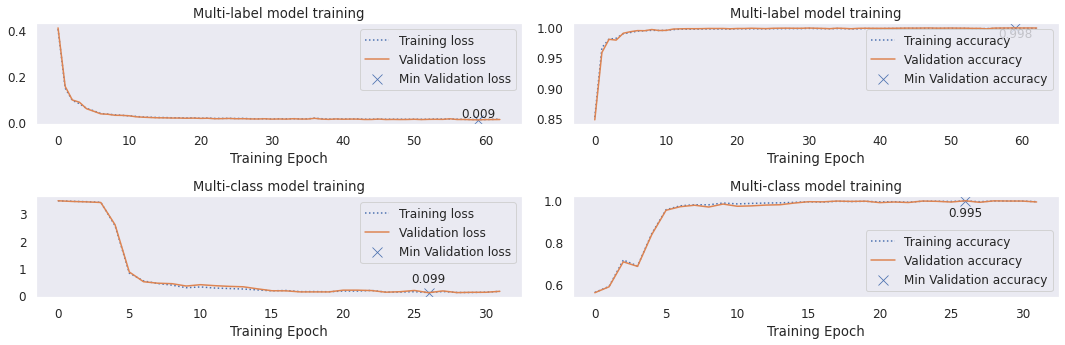

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(15,5))

sns.lineplot(x=range(ml_model.trained_epochs), y=ml_model_hist['train_loss'], label='Training loss', linestyle=':', ax=axes[0, 0])
sns.lineplot(x=range(ml_model.trained_epochs), y=ml_model_hist['val_loss'], label='Validation loss', ax=axes[0, 0])
sns.scatterplot(x=[ml_model.conv_epoch], y=ml_model_hist['val_loss'][ml_model.conv_epoch], label='Min Validation loss',
                marker='x', s=100, ax=axes[0, 0])
axes[0, 0].text(x=ml_model.conv_epoch, y=2.5 * ml_model_hist['val_loss'][ml_model.conv_epoch],
                s=round(ml_model_hist['val_loss'][ml_model.conv_epoch], 3), fontsize=12, horizontalalignment='center')
axes[0, 0].set_title('Multi-label model training')
axes[0, 0].set_xlabel('Training Epoch')
             
sns.lineplot(x=range(ml_model.trained_epochs), y=ml_model_hist['train_acc'], label='Training accuracy', linestyle=':', ax=axes[0, 1])
sns.lineplot(x=range(ml_model.trained_epochs), y=ml_model_hist['val_acc'], label='Validation accuracy', ax=axes[0, 1])
sns.scatterplot(x=[ml_model.conv_epoch], y=ml_model_hist['val_acc'][ml_model.conv_epoch], label='Min Validation accuracy',
                marker='x', s=100, ax=axes[0, 1])
axes[0, 1].text(x=ml_model.conv_epoch, y=0.985 * ml_model_hist['val_acc'][ml_model.conv_epoch],
                s=round(ml_model_hist['val_acc'][ml_model.conv_epoch], 3), fontsize=12, horizontalalignment='center')
axes[0, 1].set_title('Multi-label model training')
axes[0, 1].set_xlabel('Training Epoch')
             
sns.lineplot(x=range(mc_model.trained_epochs), y=mc_model_hist['train_loss'], label='Training loss', linestyle=':', ax=axes[1, 0])
sns.lineplot(x=range(mc_model.trained_epochs), y=mc_model_hist['val_loss'], label='Validation loss', ax=axes[1, 0])
sns.scatterplot(x=[mc_model.conv_epoch], y=mc_model_hist['val_loss'][mc_model.conv_epoch], label='Min Validation loss',
                marker='x', s=100, ax=axes[1, 0])
axes[1, 0].text(x=mc_model.conv_epoch, y=5 * mc_model_hist['val_loss'][mc_model.conv_epoch],
                s=round(mc_model_hist['val_loss'][mc_model.conv_epoch], 3), fontsize=12, horizontalalignment='center')
axes[1, 0].set_title('Multi-class model training')
axes[1, 0].set_xlabel('Training Epoch')
             
sns.lineplot(x=range(mc_model.trained_epochs), y=mc_model_hist['train_acc'], label='Training accuracy', linestyle=':', ax=axes[1, 1])
sns.lineplot(x=range(mc_model.trained_epochs), y=mc_model_hist['val_acc'], label='Validation accuracy', ax=axes[1, 1])
sns.scatterplot(x=[mc_model.conv_epoch], y=mc_model_hist['val_acc'][mc_model.conv_epoch], label='Min Validation accuracy',
                marker='x', s=100, ax=axes[1, 1])
axes[1, 1].text(x=mc_model.conv_epoch, y=0.925 * mc_model_hist['val_acc'][mc_model.conv_epoch],
                s=round(mc_model_hist['val_acc'][mc_model.conv_epoch], 3), fontsize=12, horizontalalignment='center')
axes[1, 1].set_title('Multi-class model training')
axes[1, 1].set_xlabel('Training Epoch')
plt.tight_layout()

Text(0.5, 1.0, '82.934% of samples were missclassified in 1 or fewer epochs.')

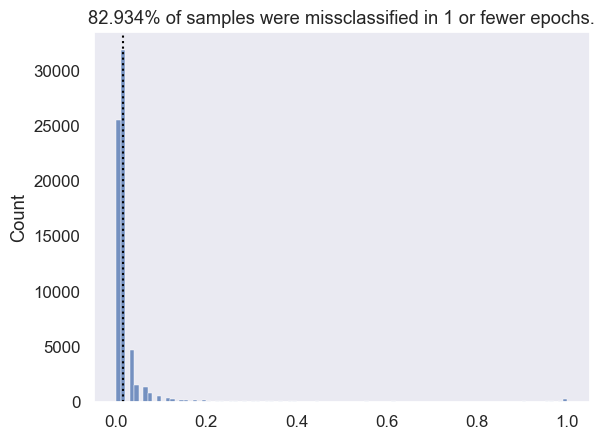

In [30]:
ml_sample_diff = np.array(ml_model_hist['sample_difficulty'])
sns.histplot(ml_sample_diff, binwidth=0.01)
plt.axvline(x = 1 / ml_model.trained_epochs, color='black', linestyle=':')
plt.title(f"{round(100* sum(ml_sample_diff <= 1 / ml_model.trained_epochs) / len(ml_sample_diff), 3)}% of samples were missclassified in 1 or fewer epochs.")

Text(0.5, 1.0, '7.06% of samples were missclassified in 1 or fewer epochs.')

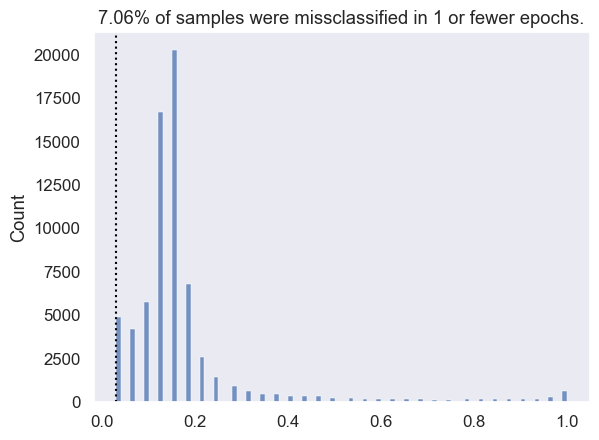

In [32]:
mc_sample_diff = np.array(mc_model_hist['sample_difficulty'])
sns.histplot(mc_sample_diff, binwidth=0.01)
plt.axvline(x = 1 / mc_model.trained_epochs, color='black', linestyle=':')
plt.title(f"{round(100* sum(mc_sample_diff <= 1 / mc_model.trained_epochs) / len(mc_sample_diff), 3)}% of samples were missclassified in 1 or fewer epochs.")

### Eval

In [18]:
ml_test_loader = myDataLoader(test_X, test_Y, batch_sz=2048)
ml_ood_loader = myDataLoader(ood_X, ood_Y, batch_sz=2048)

mc_test_loader = myDataLoader(test_X, test_Y_cat, batch_sz=2048)
mc_ood_loader = myDataLoader(ood_X, ood_Y_cat, batch_sz=2048)

In [19]:
ml_test_pred, ml_test_pred_prob = ml_model.predict(ml_test_loader, return_proba=True)
ml_ood_pred, ml_ood_pred_prob = ml_model.predict(ml_ood_loader, return_proba=True)

mc_test_pred, mc_test_pred_prob = mc_model.predict(mc_test_loader, return_proba=True)
mc_test_pred_bits = num_to_bin(mc_test_pred)
mc_ood_pred, mc_ood_pred_prob = mc_model.predict(mc_ood_loader, return_proba=True)
mc_ood_pred_bits = num_to_bin(mc_ood_pred)

In [39]:
# from .metrics import sigmoid_accuracy, softmax_accuracy, bitwise_accuracy, bitwise_recall, bitwise_precision, \
#     bitwise_F1, hamming_distances

results = pd.DataFrame(columns=[
    'Model Type', 'Configuration',
    'Character Accuracy', 'Dot Accuracy', 'Dot Recall', 'Dot Precision',
    'Dot F1', 'Hamming Distance', 'Missclassification HD'
])

preds_sets = [ml_test_pred, ml_ood_pred, mc_test_pred_bits, mc_ood_pred_bits]
labels_sets = [test_Y, ood_Y] * 2
models_sets = ['Multi-label'] * 2 + ['Multi-class'] * 2
train_sets = ['Base Train'] * 4
eval_sets = ['Base Test', 'OOD Test'] * 2

for i, (preds, labels, model, train_set, eval_set) in enumerate(zip(
    preds_sets, labels_sets, models_sets, train_sets, eval_sets
)):
    errors = np.any(preds != labels, axis=1)
    
    new_row = [
        model, f"{train_set}\n{eval_set}", sigmoid_accuracy(preds, labels), bitwise_accuracy(preds, labels),
        bitwise_recall(preds, labels), bitwise_precision(preds, labels), bitwise_F1(preds, labels), mean_hamming_distance(preds, labels),
        mean_hamming_distance(preds[errors], labels[errors])
    ]
    results.loc[results.shape[0]] = new_row
results.to_csv(os.path.join(EVAL, 'base_cbr_test_ood_metrics.csv'), index=False)

In [34]:
results = pd.read_csv(os.path.join(EVAL, 'base_cbr_test_ood_metrics.csv'))
results.Configuration = results.Configuration.str.replace('\r', '')

In [40]:
results

Model Type          Configuration  Character Accuracy  Dot Accuracy  \
0  Multi-label  Base Train\nBase Test            0.984021      0.996990   
1  Multi-label   Base Train\nOOD Test            0.938918      0.989074   
2  Multi-class  Base Train\nBase Test            0.952646      0.989611   
3  Multi-class   Base Train\nOOD Test            0.720801      0.949759   

   Dot Recall  Dot Precision    Dot F1  Hamming Distance  \
0    0.995140       0.998759  0.996946          0.018059   
1    0.995545       0.980269  0.987848          0.065553   
2    0.984464       0.994438  0.989426          0.062334   
3    0.963330       0.926912  0.944770          0.301444   

   Missclassification HD  
0               1.130208  
1               1.073197  
2               1.316344  
3               1.079677

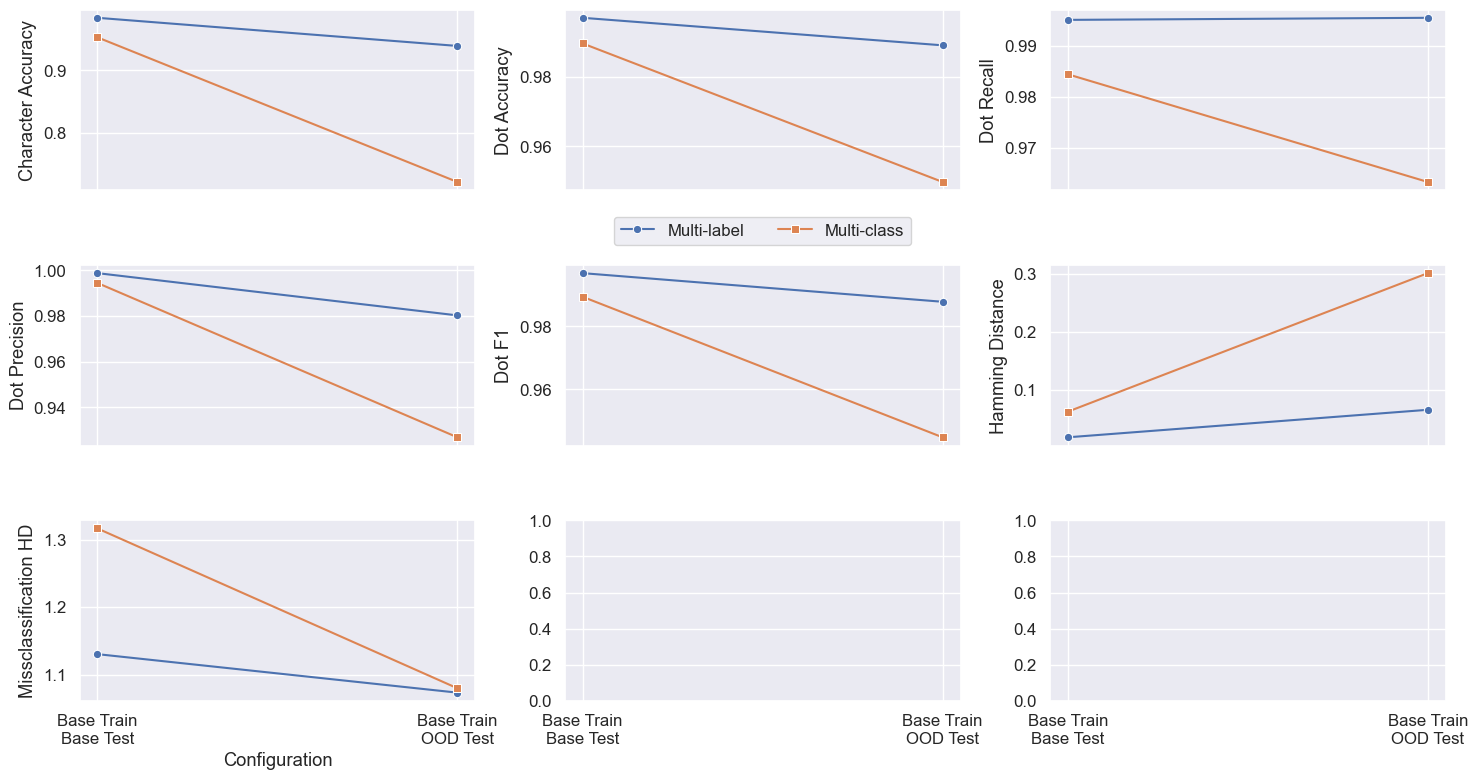

In [37]:
fig, axes = plt.subplots(3, 3, figsize=(15,8), sharex=True)
metrics = results.columns[2:]

for i, met in enumerate(metrics):
    ax = axes[i // 3, i % 3]
    sns.lineplot(data=results, x='Configuration', y=met, hue='Model Type', style='Model Type', markers=['o', 's'], dashes=False, ax=ax, legend=i==1)

axes[0,1].legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, -0.1))
plt.tight_layout()

Inverses

- Accuracy vs Error rate
- Precision vs False Positive predictions
- Recall vs False Negative predictions
- F1 vs Pseudo-average-false-predictions

In [41]:
for m, met in enumerate(metrics):
    print(f"On {met}:")
    for config in results.Configuration.unique():
        performance = results[results.Configuration == config][["Model Type", met]].set_index("Model Type")
        test_name = config.split('\n')[-1]
        if m < 5:
            ratio = performance.loc['Multi-label'] / performance.loc['Multi-class'] - 1
            print(f"Multi-label performs {round(100 * ratio.iloc[0], 3)}% higher than Multi-class on the {test_name} set.")
        else:
            ratio = 1 - performance.loc['Multi-label'] / performance.loc['Multi-class']
            print(f"Multi-label performs {round(100 * ratio.iloc[0], 3)}% lower than Multi-class on the {test_name} set.")
    print()
            

On Character Accuracy:
Multi-label performs 3.293% higher than Multi-class on the Base Test set.
Multi-label performs 30.26% higher than Multi-class on the OOD Test set.

On Dot Accuracy:
Multi-label performs 0.746% higher than Multi-class on the Base Test set.
Multi-label performs 4.139% higher than Multi-class on the OOD Test set.

On Dot Recall:
Multi-label performs 1.084% higher than Multi-class on the Base Test set.
Multi-label performs 3.344% higher than Multi-class on the OOD Test set.

On Dot Precision:
Multi-label performs 0.435% higher than Multi-class on the Base Test set.
Multi-label performs 5.756% higher than Multi-class on the OOD Test set.

On Dot F1:
Multi-label performs 0.76% higher than Multi-class on the Base Test set.
Multi-label performs 4.56% higher than Multi-class on the OOD Test set.

On Hamming Distance:
Multi-label performs 71.028% lower than Multi-class on the Base Test set.
Multi-label performs 78.254% lower than Multi-class on the OOD Test set.

On Misscl

In [29]:
1 - performance

Hamming Distance
Model Type                   
Multi-label          0.915160
Multi-class          0.840686

In [32]:
for m, met in enumerate(metrics[:-1]):
    print(f"On {met}, inversed to error rate:")
    for config in results.Configuration.unique():
        performance = 1 - results[results.Configuration == config][["Model Type", met]].set_index("Model Type") # performance as error rates
        test_name = config.split('\n')[-1]
        ratio = 1 - performance.loc['Multi-label'] / performance.loc['Multi-class']
        print(f"Multi-label approach yields a {round(100 * ratio.iloc[0], 3)}% reduction in error rate compared to Multi-class on the {test_name} set.")
    print()
            

On Character Accuracy, inversed to error rate:
Multi-label approach yields a 32.938% reduction in error rate compared to Multi-class on the Base Test set.
Multi-label approach yields a 44.795% reduction in error rate compared to Multi-class on the OOD Test set.

On Dot Accuracy, inversed to error rate:
Multi-label approach yields a 37.931% reduction in error rate compared to Multi-class on the Base Test set.
Multi-label approach yields a 46.746% reduction in error rate compared to Multi-class on the OOD Test set.

On Dot Recall, inversed to error rate:
Multi-label approach yields a 49.818% reduction in error rate compared to Multi-class on the Base Test set.
Multi-label approach yields a 82.785% reduction in error rate compared to Multi-class on the OOD Test set.

On Dot Precision, inversed to error rate:
Multi-label approach yields a 13.271% reduction in error rate compared to Multi-class on the Base Test set.
Multi-label approach yields a 32.431% reduction in error rate compared to M

In [26]:
class_freqs = pd.DataFrame()
class_freqs.index.name = 'Class'
class_freqs['Percent of Train set'] = train_Y_cat.sum(axis=0) / train_Y.shape[0] * 100
class_freqs['Rank in Train set'] = class_freqs.sort_values('Percent of Train set', ascending=False).reset_index().sort_values('Class').index
class_freqs['Percent of Test set'] = test_Y_cat.sum(axis=0) / test_Y.shape[0] * 100
class_freqs['Rank in Test set'] = class_freqs.sort_values('Percent of Test set', ascending=False).reset_index().sort_values('Class').index
class_freqs['Percent of OOD set'] = ood_Y_cat.sum(axis=0) / ood_Y.shape[0] * 100
class_freqs['Rank in OOD set'] = class_freqs.sort_values('Percent of OOD set', ascending=False).reset_index().sort_values('Class').index
label_freqs = pd.DataFrame()
label_freqs.index.name = 'Label'
label_freqs['Percent of Train set'] = train_Y.sum(axis=0) / train_Y.shape[0] * 100
label_freqs['Rank in Train set'] = label_freqs.sort_values('Percent of Train set', ascending=False).reset_index().sort_values('Label').index
label_freqs['Percent of Test set'] = test_Y.sum(axis=0) / test_Y.shape[0] * 100
label_freqs['Rank in Test set'] = label_freqs.sort_values('Percent of Test set', ascending=False).reset_index().sort_values('Label').index
label_freqs['Percent of OOD set'] = ood_Y.sum(axis=0) / ood_Y.shape[0] * 100
label_freqs['Rank in OOD set'] = label_freqs.sort_values('Percent of OOD set', ascending=False).reset_index().sort_values('Label').index
display(class_freqs.head())
display(label_freqs)

Percent of Train set  Rank in Train set  Percent of Test set  \
Class                                                                 
0                  0.000000                 63             0.000000   
1                  8.217477                  1             7.723036   
2                  2.090462                 15             2.097204   
3                  1.824823                 19             1.797603   
4                  0.093840                 47             0.024967   

       Rank in Test set  Percent of OOD set  Rank in OOD set  
Class                                                         
0                    63            0.000000               63  
1                     1            2.413045               12  
2                    15            1.420212               25  
3                    20            2.480987               11  
4                    52            1.808140               15

Percent of Train set  Rank in Train set  Percent of Test set  \
Label                                                                 
0                 65.849539                  0            65.354527   
1                 50.929014                  3            51.314913   
2                 55.916959                  1            55.575899   
3                 47.403525                  4            47.819574   
4                 52.671546                  2            53.170772   
5                 22.727995                  5            22.986019   

       Rank in Test set  Percent of OOD set  Rank in OOD set  
Label                                                         
0                     0           47.894887                2  
1                     3           48.190764                1  
2                     1           42.157056                3  
3                     4           39.862362                4  
4                     2           53.915445                0  
5                     5           35.621452                5

In [ ]:
# from .metrics import sigmoid_accuracy, softmax_accuracy, bitwise_accuracy, bitwise_recall, bitwise_precision, \
#     bitwise_F1, hamming_distances

per_class_results = pd.DataFrame(columns=[
    'Model Type', 'Configuration', 'Class',
    'Character Accuracy', 'Dot Accuracy', 'Dot Recall', 'Dot Precision',
    'Dot F1', 'Hamming Distance'
])

preds_sets = [ml_test_pred, ml_ood_pred, mc_test_pred_bits, mc_ood_pred_bits]
labels_sets = [test_Y, ood_Y] * 2
models_sets = ['Multi-label'] * 2 + ['Multi-class'] * 2
train_sets = ['Base Train'] * 4
eval_sets = ['Base Test', 'OOD Test'] * 2

for i, (preds, labels, model, train_set, eval_set) in enumerate(zip(
    preds_sets, labels_sets, models_sets, train_sets, eval_sets
)):

    for c in range(64):
        class_mask = bin_to_num(labels) == c
        mets = [c]
        if not np.any(class_mask):
            mets += [np.nan] * 6
        else:
            class_preds = preds[class_mask]
            class_labels = labels[class_mask]
            mets += [sigmoid_accuracy(class_preds, class_labels), bitwise_accuracy(class_preds, class_labels),
                   bitwise_recall(class_preds, class_labels), bitwise_precision(class_preds, class_labels),
                   bitwise_F1(class_preds, class_labels), mean_hamming_distance(class_preds, class_labels)
                  ]
        new_row = [model, f"{train_set}\n{eval_set}"] + mets
        per_class_results.loc[per_class_results.shape[0]] = new_row


In [ ]:
per_class_results = per_class_results.merge(class_freqs, on='Class')
per_class_results.head()

Model Type          Configuration  Class  Character Accuracy  \
0  Multi-label  Base Train\nBase Test      0                 NaN   
1  Multi-label   Base Train\nOOD Test      0                 NaN   
2  Multi-class  Base Train\nBase Test      0                 NaN   
3  Multi-class   Base Train\nOOD Test      0                 NaN   
4  Multi-label  Base Train\nBase Test      1            0.980603   

   Dot Accuracy  Dot Recall  Dot Precision  Dot F1  Hamming Distance  \
0           NaN         NaN            NaN     NaN               NaN   
1           NaN         NaN            NaN     NaN               NaN   
2           NaN         NaN            NaN     NaN               NaN   
3           NaN         NaN            NaN     NaN               NaN   
4      0.996228    0.998922       0.978881  0.9888          0.022629   

   Percent of Train set  Rank in Train set  Percent of Test set  \
0              0.000000                 63             0.000000   
1              0.000000                 63             0.000000   
2              0.000000                 63             0.000000   
3              0.000000                 63             0.000000   
4              8.217477                  1             7.723036   

   Rank in Test set  Percent of OOD set  Rank in OOD set  
0                63            0.000000               63  
1                63            0.000000               63  
2                63            0.000000               63  
3                63            0.000000               63  
4                 1            2.413045               12

In [88]:
# per_class_results.to_csv(os.path.join(EVAL, 'base_cbr_per_class_metrics.csv'), index=False)
per_class_results = pd.read_csv(os.path.join(EVAL, 'base_cbr_per_class_metrics.csv'))
per_class_results.Configuration = per_class_results.Configuration.str.replace('\r', '')

In [54]:
def get_ranks(g, met='Character Accuracy'):
    gs = g.sort_values(met, ascending=False)
    gs['Performance Rank'] = range(len(gs))
    return gs
# per_class_results.groupby(['Model Type', 'Configuration']).apply(get_ranks).reset_index(drop=True)

In [55]:

# from whittaker_eilers import WhittakerSmoother

# def optimal_smooth(series, order, bsc=False):
#     WS = WhittakerSmoother(lmbda=1, order=order, data_length=len(series), weights=~pd.isna(series))
#     WS_o = WS.smooth_optimal(series.fillna(0.), break_serial_correlation=bsc)
    
#     return WS_o.get_optimal().get_smoothed()

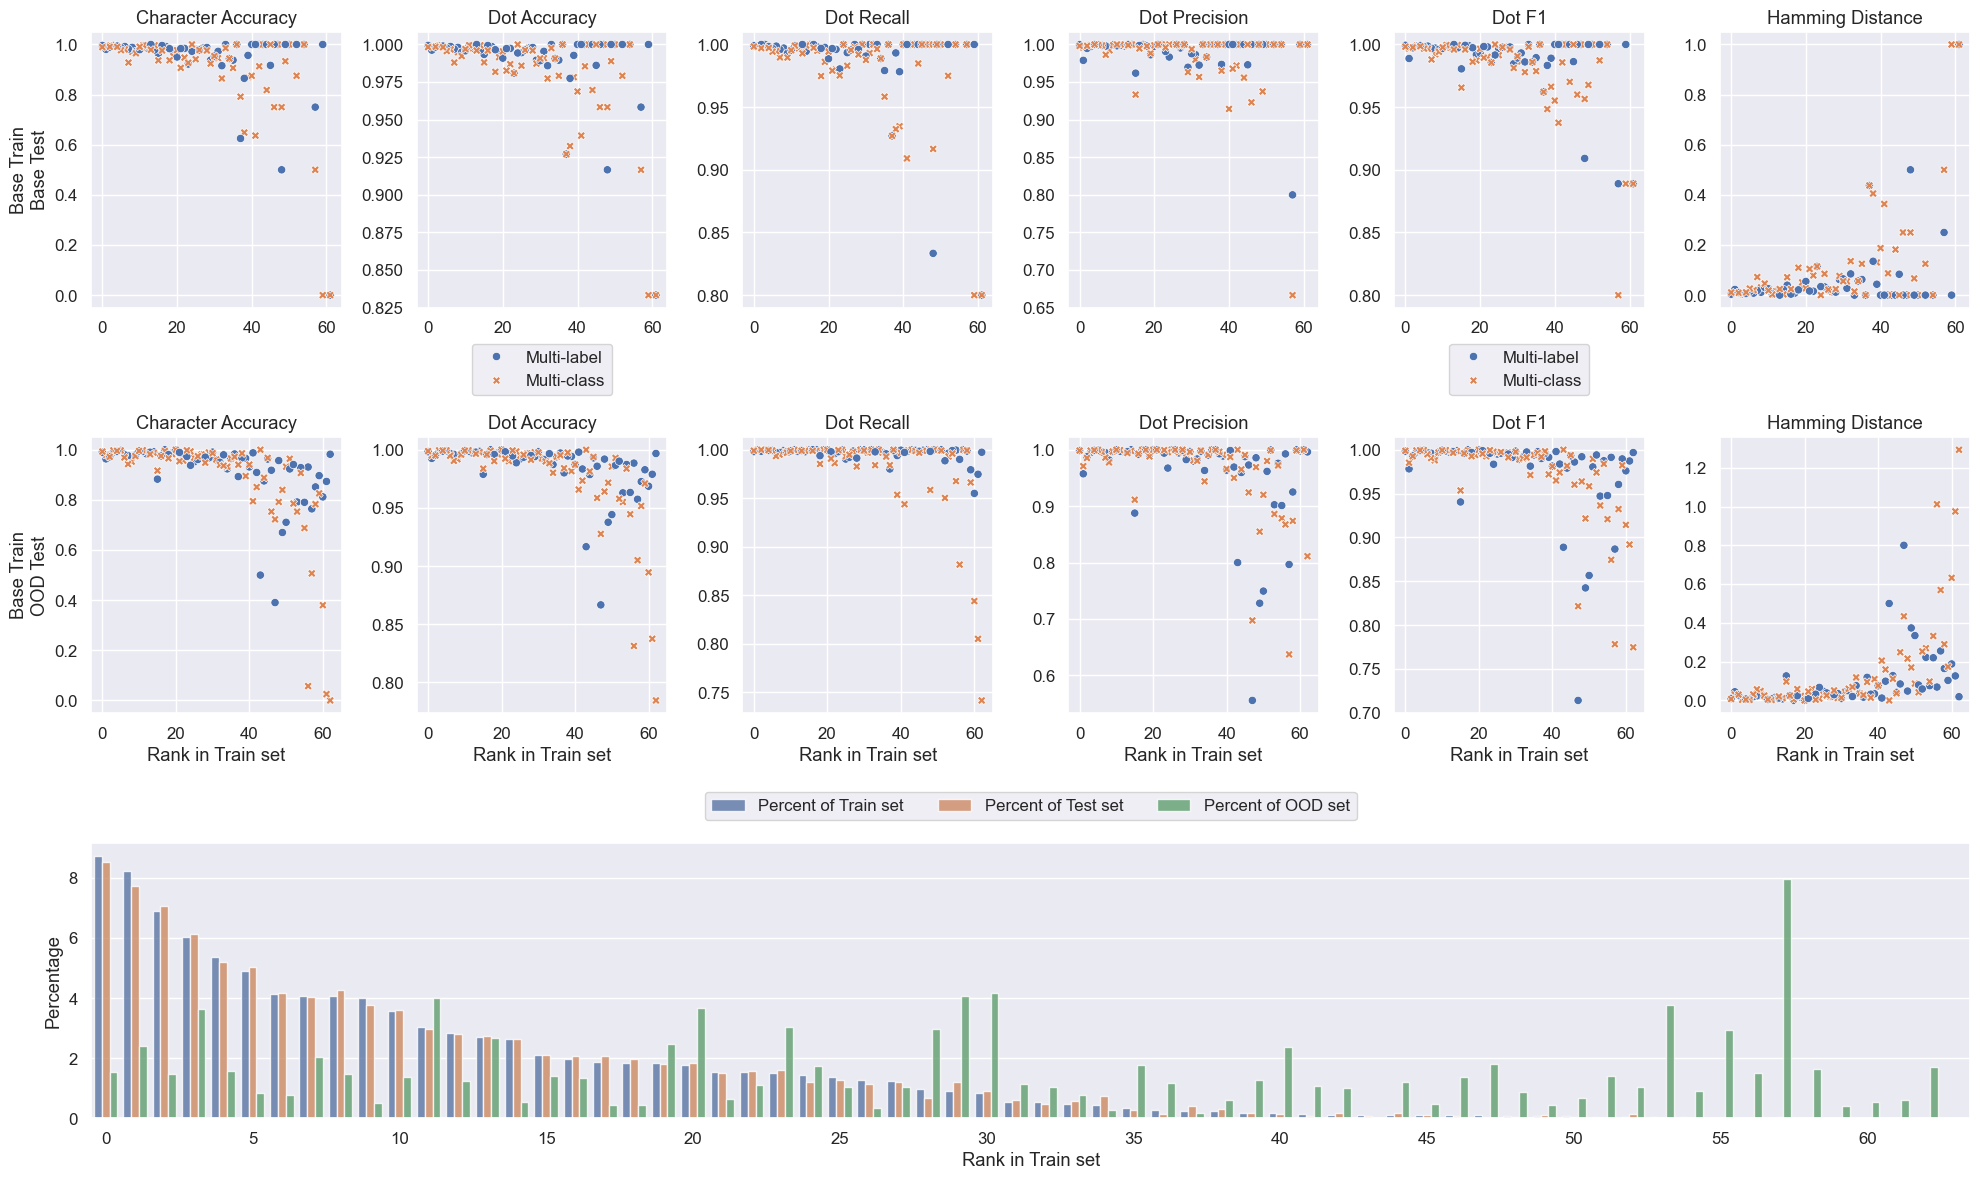

In [89]:
metrics = results.columns[2:]
M = len(metrics)
# fig, axes = plt.subplots(3, M, figsize=(20,12), sharex=True)
plt.figure(figsize=(20,12))
ax1 = [plt.subplot(3,6,a) for a in range(1,7)]
ax2 = [plt.subplot(3,6,a) for a in range(7,13)]
ax3 = plt.subplot(3,1,3)
axes = [ax1, ax2, ax3]

for i, met in enumerate(metrics):
    for c, con in enumerate(per_class_results['Configuration'].unique()):
        ax = axes[c][i]
        sns.scatterplot(data=per_class_results[per_class_results.Configuration == con],
                     x='Rank in Train set', y=met,
                     hue='Model Type', style='Model Type', markers=True,
                     ax=ax, legend=(i in [1,4] and c==0))
        if i == 0:
            ax.set_ylabel(con)
        else:
            ax.set_ylabel('')
        if c == 0:
            ax.set_xlabel('')
        ax.set_title(met)

axes[0][1].legend(ncol=1, loc='upper center', bbox_to_anchor=(0.5, -.1))
axes[0][4].legend(ncol=1, loc='upper center', bbox_to_anchor=(0.5, -.1))
xs = range(0, 64, 5)
ax = axes[2]
data = pd.melt(class_freqs, id_vars=['Rank in Train set', 'Rank in Test set', 'Rank in OOD set'],
        value_vars=['Percent of Train set', 'Percent of Test set', 'Percent of OOD set'], var_name='Dataset', value_name='Percentage')
sns.barplot(data=data, x='Rank in Train set', y='Percentage',
            hue='Dataset', alpha=0.8, ax=ax)
ax.legend(ncol=3, loc='lower center', bbox_to_anchor=(0.5, 1.05))
ax.set_xticks(xs)
plt.tight_layout()

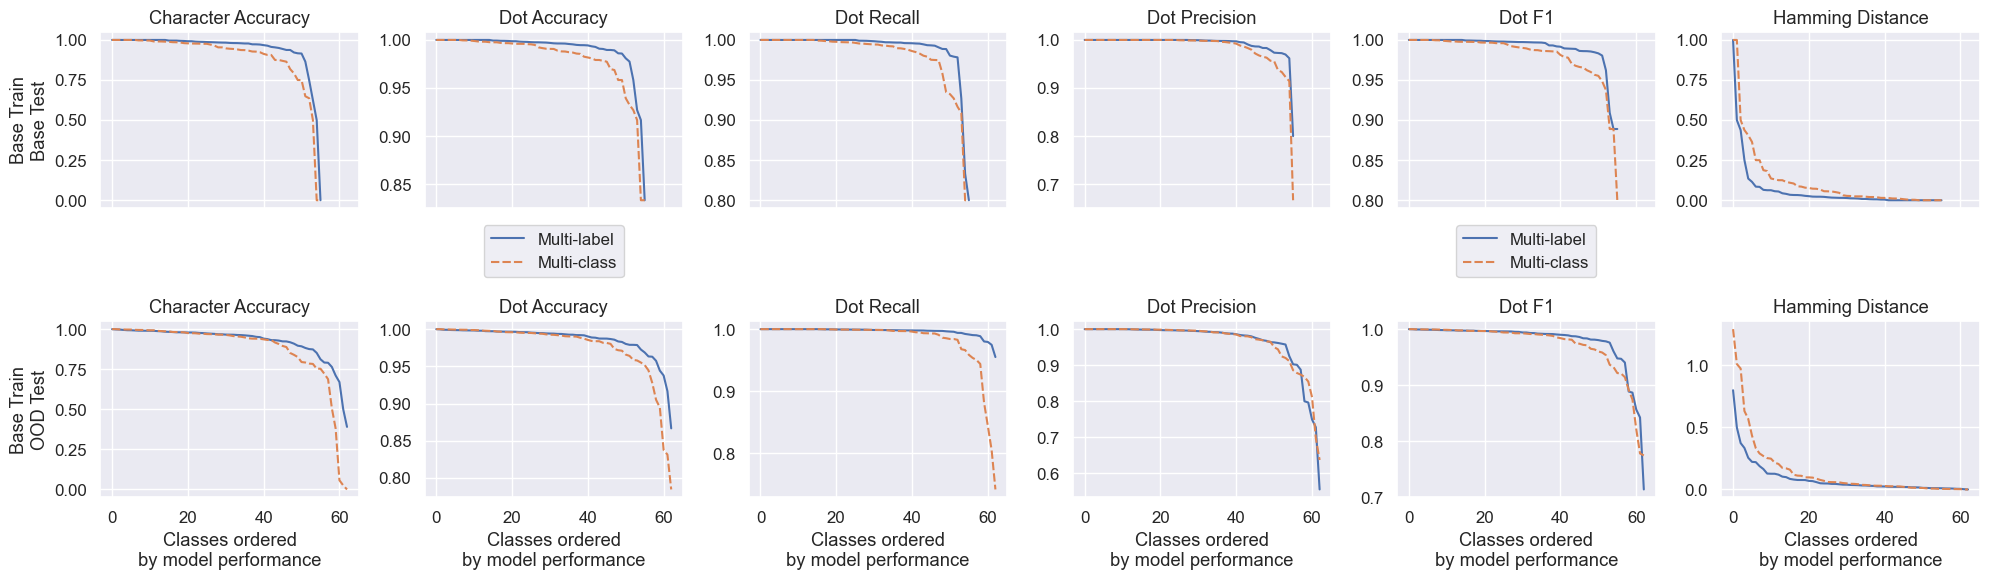

In [102]:
metrics = results.columns[2:]
M = len(metrics)
fig, axes = plt.subplots(2, M, figsize=(20,6), sharex=True)
ORDER = ['Multi-label', 'Multi-class']

for i, met in enumerate(metrics):
    for c, con in enumerate(per_class_results['Configuration'].unique()):
        ax = axes[c,i]
        # ax.grid(False)
        data = per_class_results[per_class_results.Configuration == con].groupby('Model Type').apply(get_ranks, met=met).reset_index(drop=True)
        sns.lineplot(data=data,
                     x='Performance Rank',
                     y=met,
                     hue='Model Type', style='Model Type', hue_order=ORDER, style_order=ORDER,
                     ax=ax, legend=(i in [1,4] and c==0))
        ax.set_xlabel('Classes ordered\nby model performance')
        if i == 0:
            ax.set_ylabel(con)
        else:
            ax.set_ylabel('')
        ax.set_title(met)    
        # ax2 = ax.twinx()
        # sns.barplot(data=data, x='Performance Rank', y='Percent of Train set',
        #             hue='Model Type', ax=ax2)

axes[0,1].legend(ncol=1, loc='upper center', bbox_to_anchor=(0.5, -.05))
axes[0,4].legend(ncol=1, loc='upper center', bbox_to_anchor=(0.5, -.05))
plt.tight_layout()

In [ ]:
# from .metrics import sigmoid_accuracy, softmax_accuracy, bitwise_accuracy, bitwise_recall, bitwise_precision, \
#     bitwise_F1, hamming_distances

per_label_results = pd.DataFrame(columns=[
    'Model Type', 'Configuration', 'Label',
    'Dot Accuracy', 'Dot Recall', 'Dot Precision', 'Dot F1'
])

preds_sets = [ml_test_pred, ml_ood_pred, mc_test_pred_bits, mc_ood_pred_bits]
labels_sets = [test_Y, ood_Y] * 2
models_sets = ['Multi-label'] * 2 + ['Multi-class'] * 2
train_sets = ['Base Train'] * 4
eval_sets = ['Base Test', 'OOD Test'] * 2

for i, (preds, labels, model, train_set, eval_set) in enumerate(zip(
    preds_sets, labels_sets, models_sets, train_sets, eval_sets
)):
    TP, TN, FP, FN = macro_metrics(preds, labels)
    HAMS = hamming_distances(class_preds, class_labels)
    for l in range(6):
        mets = [l]
        tp, tn, fp, fn = TP[l], TN[l], FP[l], FN[l]
        mets += [(tp+tn) / (tp+tn+fp+fn),
                 tp / (tp + fn), tp / (tp + fp),
                 tp / (tp + 0.5 * (fp + fn))
                ]
        new_row = [model, f"{train_set}\n{eval_set}"] + mets
        per_label_results.loc[per_label_results.shape[0]] = new_row


In [ ]:
per_label_results = per_label_results.merge(label_freqs, on='Label')
per_label_results.head()

Model Type          Configuration  Label  Dot Accuracy  Dot Recall  \
0  Multi-label  Base Train\nBase Test      0      0.997503    0.997453   
1  Multi-label   Base Train\nOOD Test      0      0.979508    0.999085   
2  Multi-class  Base Train\nBase Test      0      0.997587    0.998345   
3  Multi-class   Base Train\nOOD Test      0      0.956911    0.995699   
4  Multi-label  Base Train\nBase Test      1      0.996921    0.996594   

   Dot Precision    Dot F1  Percent of Train set  Rank in Train set  \
0       0.998725  0.998089             65.849539                  0   
1       0.959777  0.979036             65.849539                  0   
2       0.997963  0.998154             65.849539                  0   
3       0.920782  0.956776             65.849539                  0   
4       0.997403  0.996998             50.929014                  3   

   Percent of Test set  Rank in Test set  Percent of OOD set  Rank in OOD set  
0            65.354527                 0           47.894887                2  
1            65.354527                 0           47.894887                2  
2            65.354527                 0           47.894887                2  
3            65.354527                 0           47.894887                2  
4            51.314913                 3           48.190764                1

In [91]:
# per_label_results.to_csv(os.path.join(EVAL, 'base_cbr_per_label_metrics.csv'), index=False)
per_label_results = pd.read_csv(os.path.join(EVAL, 'base_cbr_per_label_metrics.csv'))
per_label_results.Configuration = per_label_results.Configuration.str.replace('\r', '')

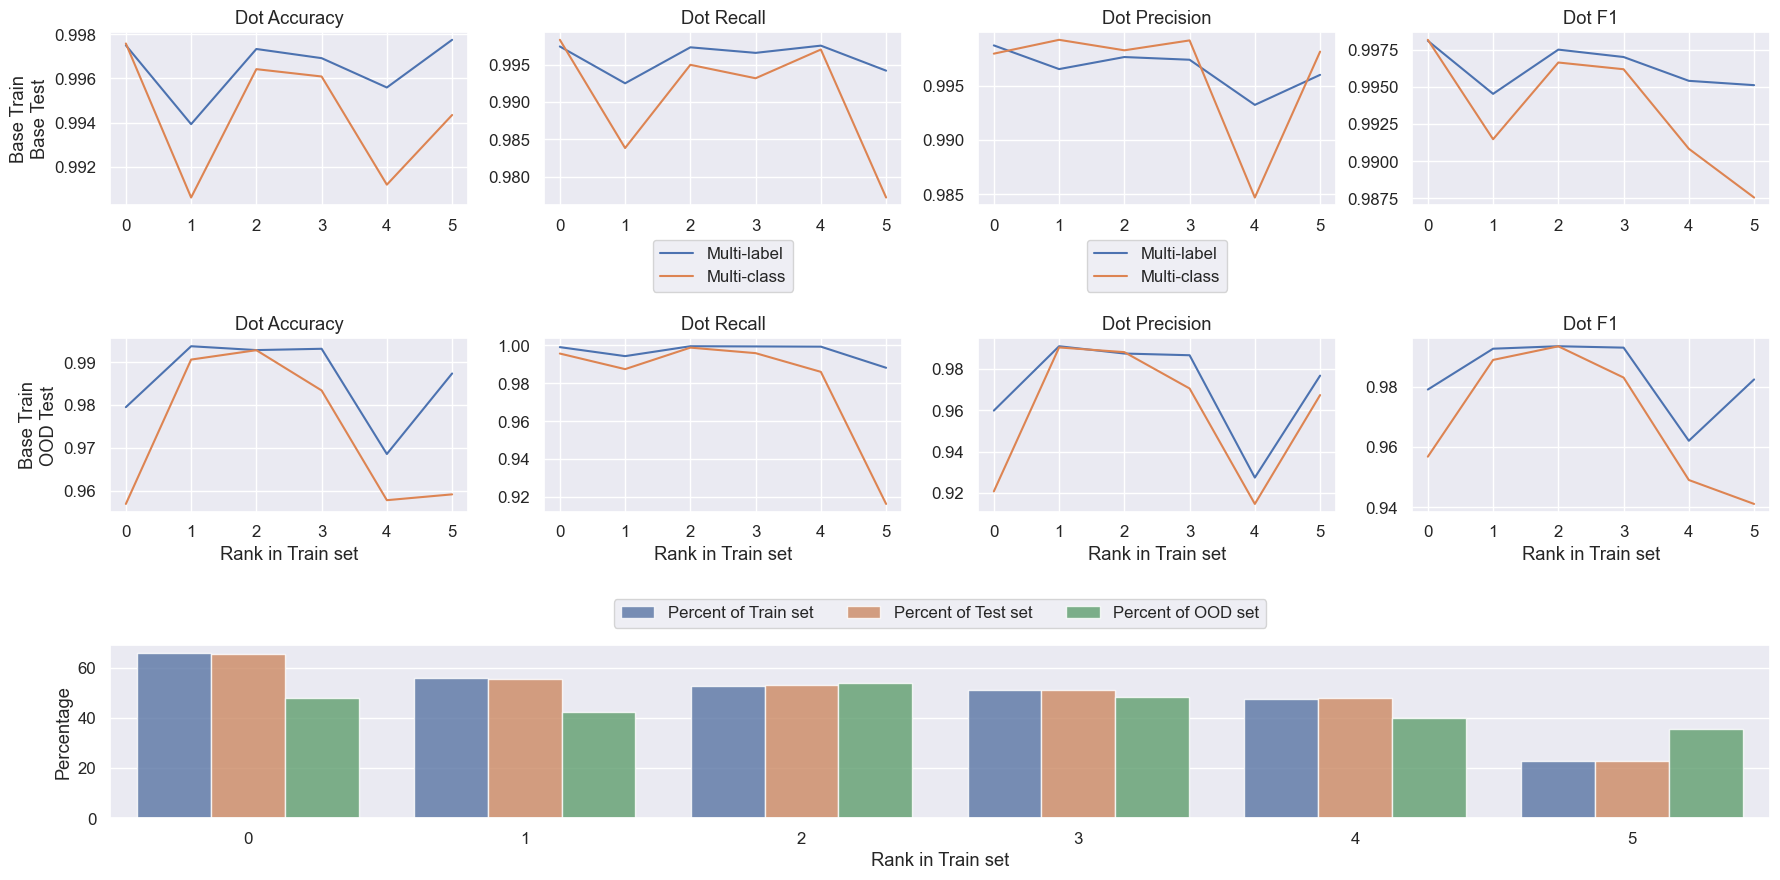

In [98]:
metrics = results.columns[3:7]
M = len(metrics)
# fig, axes = plt.subplots(3, M, figsize=(18,9), sharex=True, sharey='row')
plt.figure(figsize=(18,9))
ax1 = [plt.subplot(3,M,a) for a in range(1,M+1)]
ax2 = [plt.subplot(3,M,a) for a in range(M+1,2*M+1)]
ax3 = plt.subplot(3,1,3)
axes = [ax1, ax2, ax3]

for i, met in enumerate(metrics):
    # met_smoothed = optimal_smooth(per_class_results[met], order=20)
    met_smoothed = per_label_results[met]
    for c, con in enumerate(per_label_results['Configuration'].unique()):
        ax = axes[c][i]
        # ax.grid(False)
        sns.lineplot(data=per_label_results[per_label_results.Configuration == con],
                     x='Rank in Train set', y=met_smoothed,
                     hue='Model Type', #style='Model Type',
                     ax=ax, legend=(i in [1,2] and c==0))
        if i == 0:
            ax.set_ylabel(con)
        else:
            ax.set_ylabel('')
        ax.set_title(met)
        if c == 0:
            ax.set_xlabel('')

axes[0][1].legend(ncol=1, loc='upper center', bbox_to_anchor=(0.5, -.15))
axes[0][2].legend(ncol=1, loc='upper center', bbox_to_anchor=(0.5, -.15))

xs = range(0, 6)
ax = axes[2]
data = pd.melt(label_freqs, id_vars=['Rank in Train set', 'Rank in Test set', 'Rank in OOD set'],
        value_vars=['Percent of Train set', 'Percent of Test set', 'Percent of OOD set'], var_name='Dataset', value_name='Percentage')
sns.barplot(data=data, x='Rank in Train set', y='Percentage',
            hue='Dataset', alpha=0.8, ax=ax)
ax.legend(ncol=3, loc='lower center', bbox_to_anchor=(0.5, 1.05))
ax.set_xticks(xs)
plt.tight_layout()

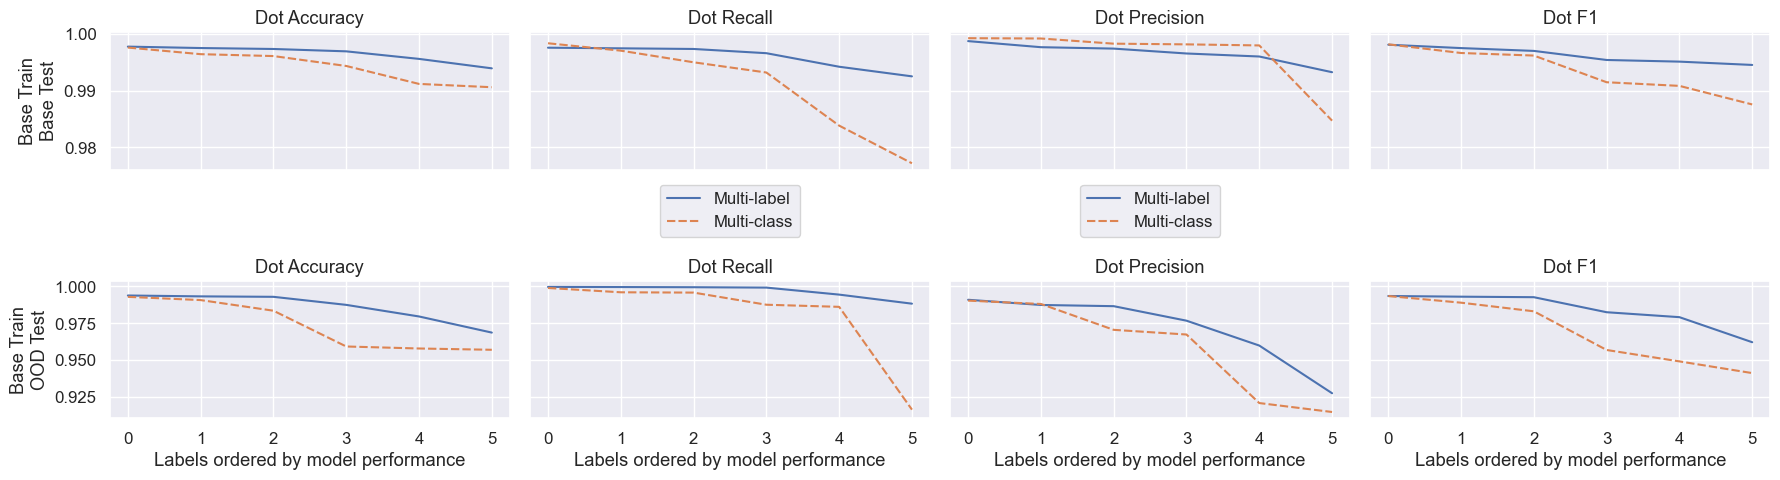

In [103]:
metrics = results.columns[3:7]
M = len(metrics)
fig, axes = plt.subplots(2, M, figsize=(18,5), sharex=True, sharey='row')

for i, met in enumerate(metrics):
    for c, con in enumerate(per_label_results['Configuration'].unique()):
        ax = axes[c,i]
        # ax.grid(False)
        if i == 0:
            ax.set_ylabel(con)
        ax.set_title(met)
        data = per_label_results[per_label_results.Configuration == con].groupby('Model Type').apply(get_ranks, met=met).reset_index(drop=True)
        sns.lineplot(data=data,
                     x='Performance Rank',
                     y=met,
                     hue='Model Type', style='Model Type',
                     hue_order=ORDER, style_order=ORDER,
                     ax=ax, legend=(i in [1,2] and c==0))
        ax.set_xlabel('Labels ordered by model performance')

axes[0,1].legend(ncol=1, loc='upper center', bbox_to_anchor=(0.5, -.05))
axes[0,2].legend(ncol=1, loc='upper center', bbox_to_anchor=(0.5, -.05))
plt.tight_layout()